# Load the data and libraries

In [1]:
%load_ext jupyter_black

In [16]:
import pandas as pd
import numpy as np

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, EngFormatter, PercentFormatter
import plotly.express as px
from siuba.dply.forcats import fct_lump
from sklearn.preprocessing import LabelEncoder

plt.rcParams["figure.figsize"] = (11, 7)
pd.set_option("display.max_columns", 20)

In [17]:
students = pd.read_csv("../data/students_processed_cats.csv")

In [18]:
students.head()

marital_status  application_mode  application_order  course  \
0             NaN               NaN                  5     NaN   
1             NaN               NaN                  1     NaN   
2             NaN               NaN                  5     NaN   
3             NaN               NaN                  2     NaN   
4             NaN               NaN                  1     NaN   

   daytime/evening_attendance  previous_qualification  nationality  \
0                         NaN                     NaN          NaN   
1                         NaN                     NaN          NaN   
2                         NaN                     NaN          NaN   
3                         NaN                     NaN          NaN   
4                         NaN                     NaN          NaN   

   mother's_qualification  father's_qualification  mother's_occupation  ...  \
0                     NaN                     NaN                  NaN  ...   
1                     NaN                     NaN                  NaN  ...   
2                     NaN                     NaN                  NaN  ...   
3                     NaN                     NaN                  NaN  ...   
4                     NaN                     NaN                  NaN  ...   

   curricular_units_2nd_sem_(credited)  curricular_units_2nd_sem_(enrolled)  \
0                                    0                                    0   
1                                    0                                    6   
2                                    0                                    6   
3                                    0                                    6   
4                                    0                                    6   

   curricular_units_2nd_sem_(evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   curricular_units_2nd_sem_(approved)  curricular_units_2nd_sem_(grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   curricular_units_2nd_sem_(without_evaluations)  unemployment_rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   inflation_rate   gdp    target  
0             1.4  1.74   Dropout  
1            -0.3  0.79  Graduate  
2             1.4  1.74   Dropout  
3            -0.8 -3.12  Graduate  
4            -0.3  0.79  Graduate  

[5 rows x 35 columns]

# Target variable analysis

In [19]:
students.target.unique()

array(['Dropout', 'Graduate', 'Enrolled'], dtype=object)

Transform this column to order categorical

In [20]:
target_order = ["Dropout", "Enrolled", "Graduate"]
target_palette = {"Graduate": "#4ECDC4", "Enrolled": "#FFE66D", "Dropout": "#FF6B6B"}
students["target"] = (
    students["target"].astype("category").cat.reorder_categories(target_order)
)

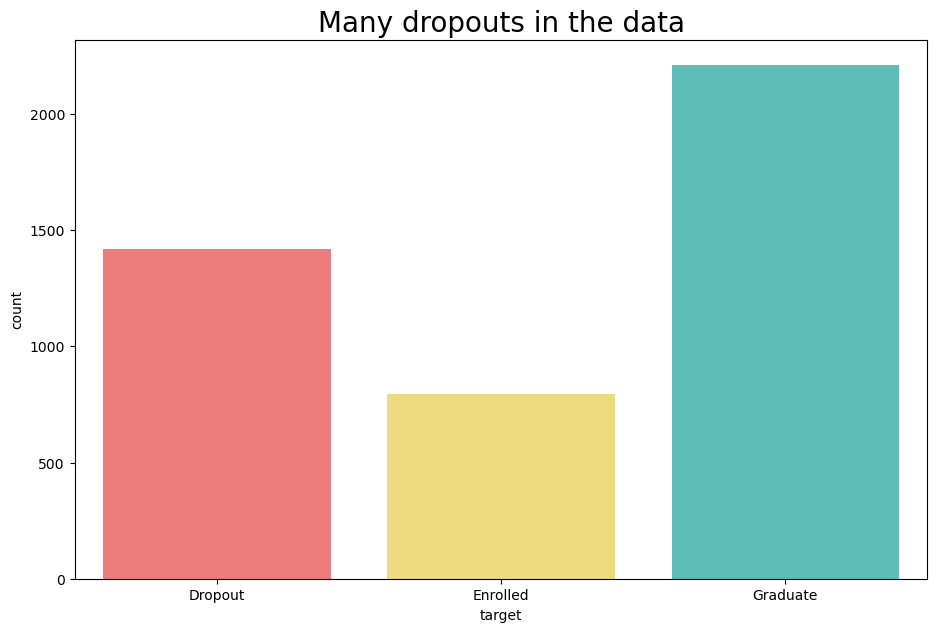

In [21]:
sns.countplot(students, x="target", palette=target_palette)
plt.title("Many dropouts in the data", fontsize=20)
plt.show()

In [56]:
students.target.value_counts(sort = False, normalize=True)

Dropout     0.321203
Enrolled    0.179476
Graduate    0.499322
Name: target, dtype: float64

Only 50% of the initial students graduates on time, 32% leave the course and 18% continue studying and the end of the regular course. Almost 1/3 of the total dropout the school.

# Univariate analysis (relation with target)

In [57]:
def plot_proportions(data, var, size = (13,6)):
    var_title = var.replace("_"," ").title()
    data_filter = data.groupby(var, as_index = False)["target"].value_counts()
    data_filter["proportion"] = data_filter.groupby(var)["count"].transform(lambda x: x / sum(x))
    y_order = data_filter.query("target == 'Graduate'").sort_values("proportion", ascending = False)[var].values
    return (
       so.Plot(data_filter, y = var, color = "target")
       .pair(x = ["proportion", "count"])
       .layout(size = size, engine = "tight")
       .add(so.Bar(), so.Dodge())
       .scale(color=so.Nominal(order=target_order[::-1], values = target_palette),
              y = so.Nominal(order = y_order),
              x0 = so.Continuous().label(like = "{x:.0%}"))
       .label(y = var_title,
              x0 = lambda x: x.title(),
              x1 = lambda x: x.title(),
              color = "Target")
       .theme({**axes_style("white")})
    )

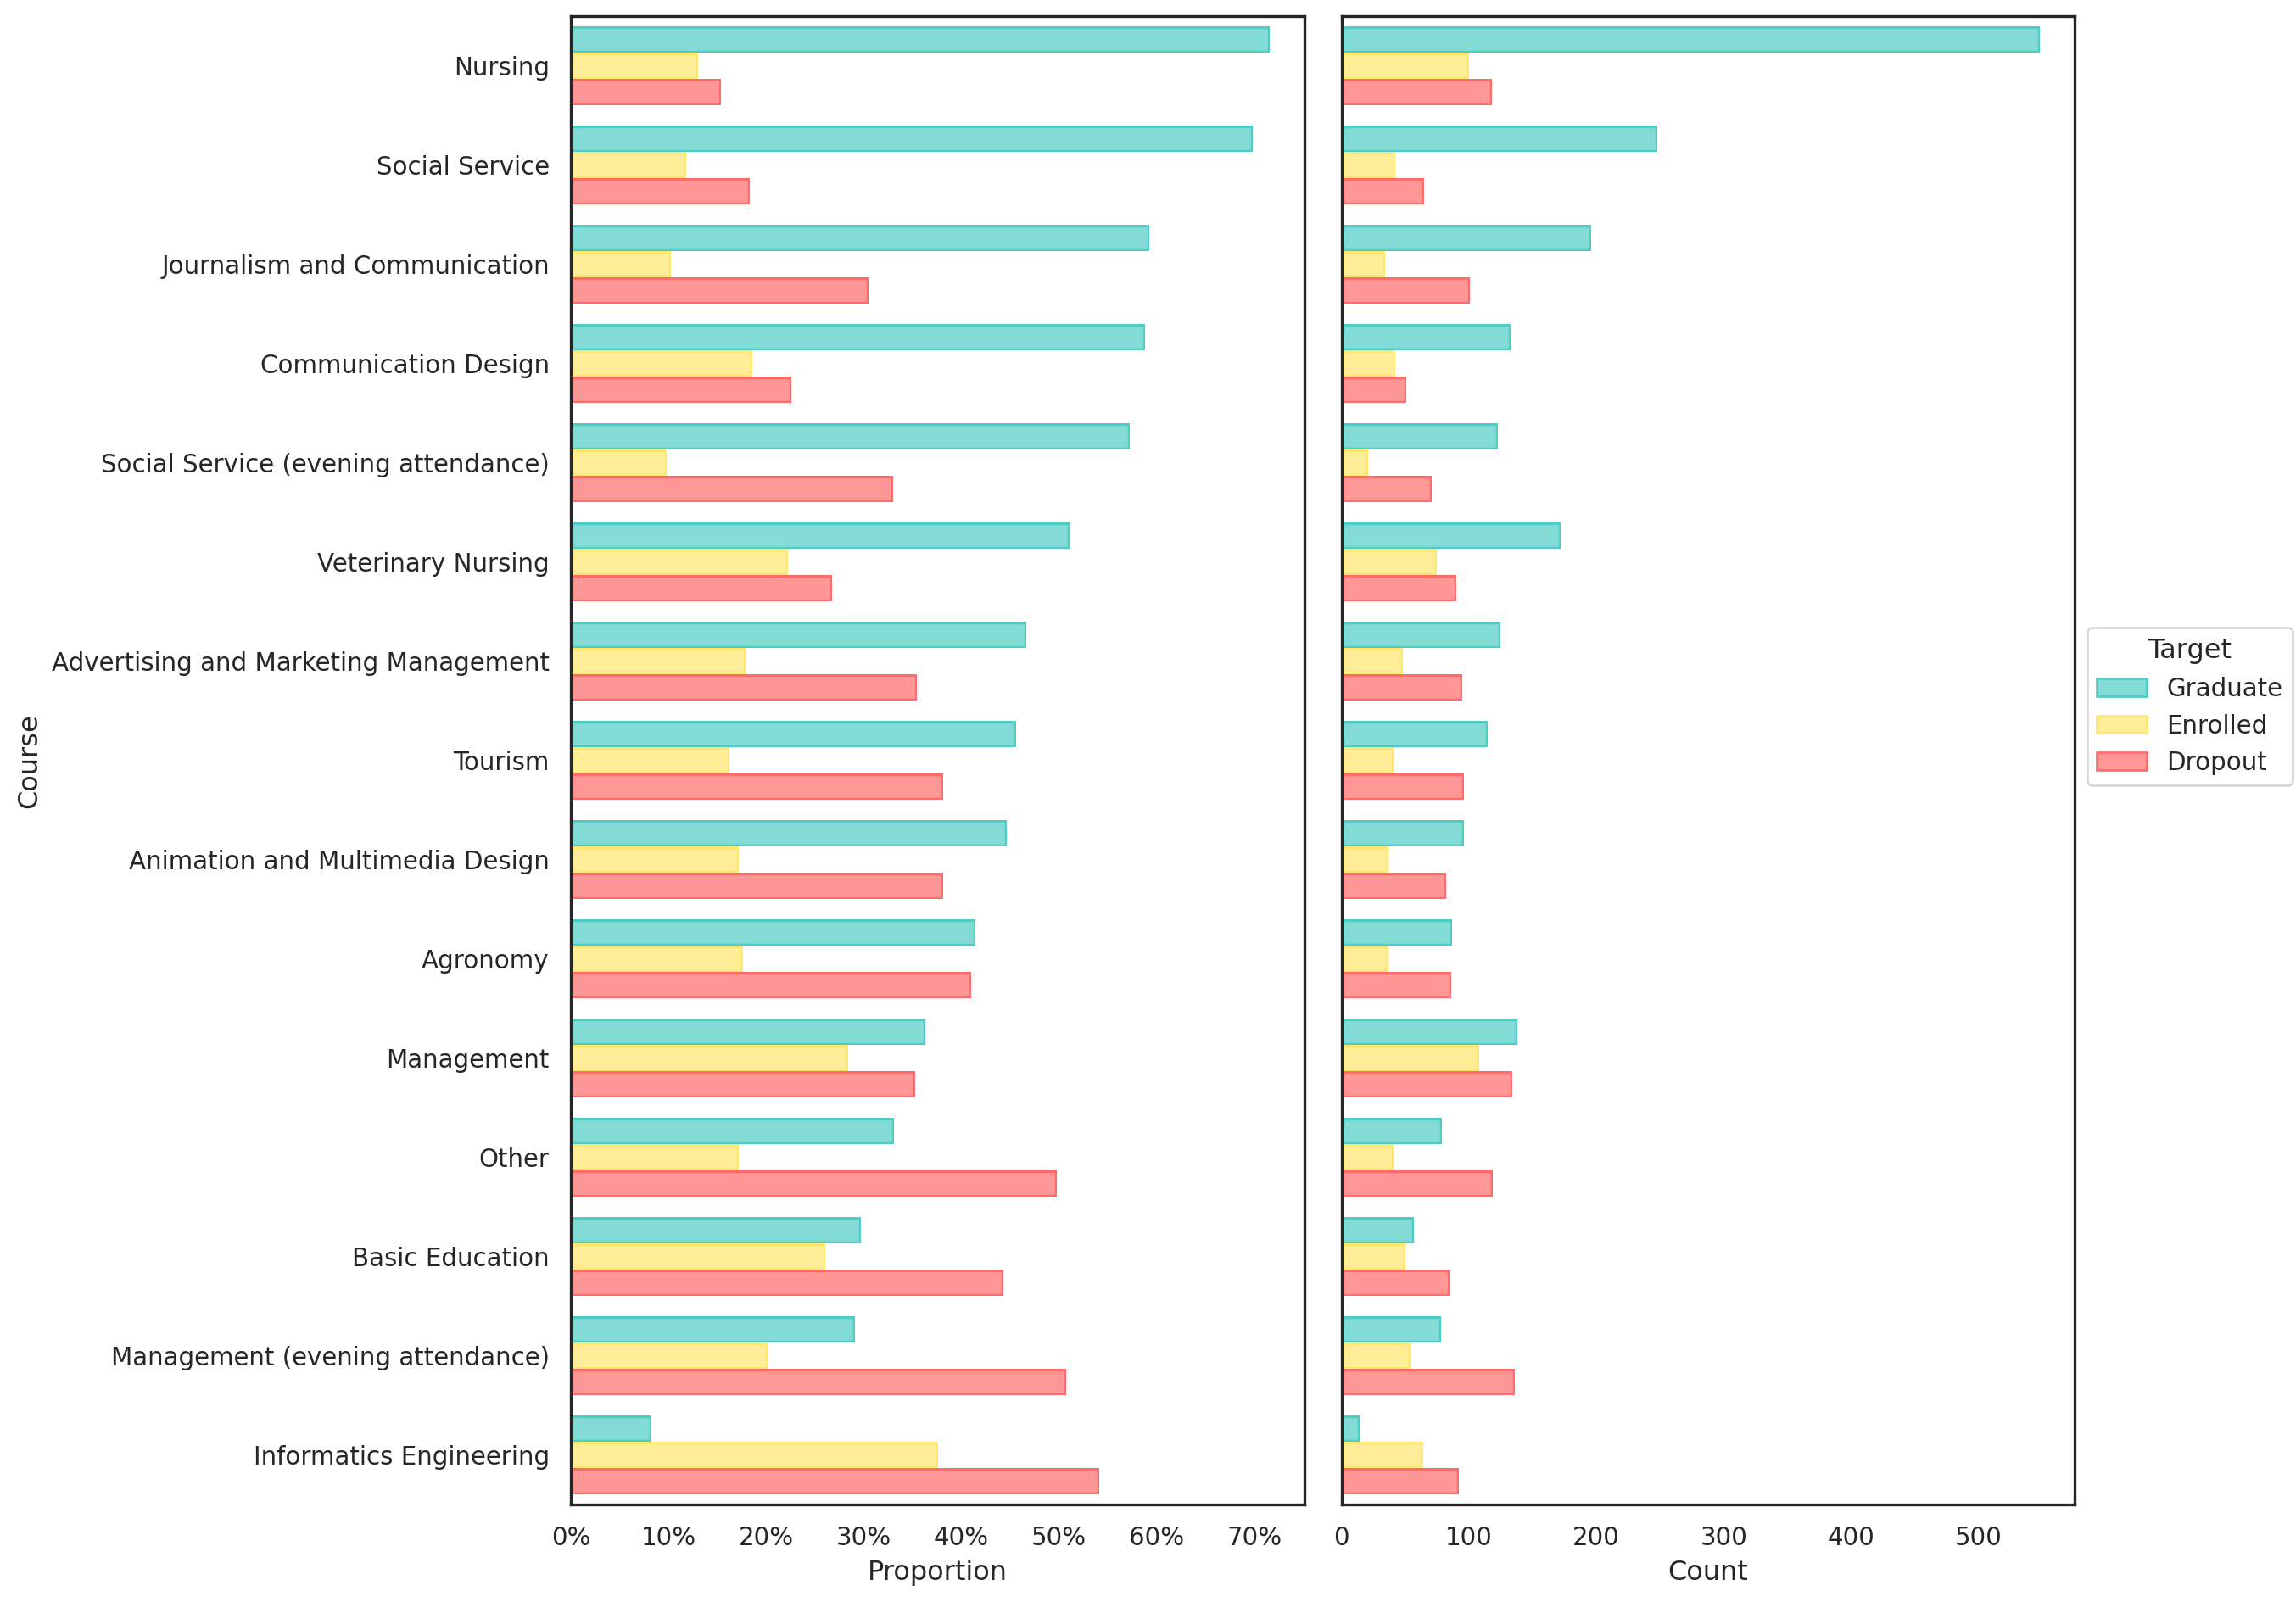

In [58]:
students.assign(course = lambda x: fct_lump(x.course, 14)).pipe(plot_proportions, "course", (13,10))

The course have a strong correlation with graduation rate. In the nursing course, 70% of the total students graduate, while less than 10% graduates in informatics engineering.

Also there are only 2 courses in the evening (Management and Social service), in both cases the dropout rate is higher in the evening than in the morning

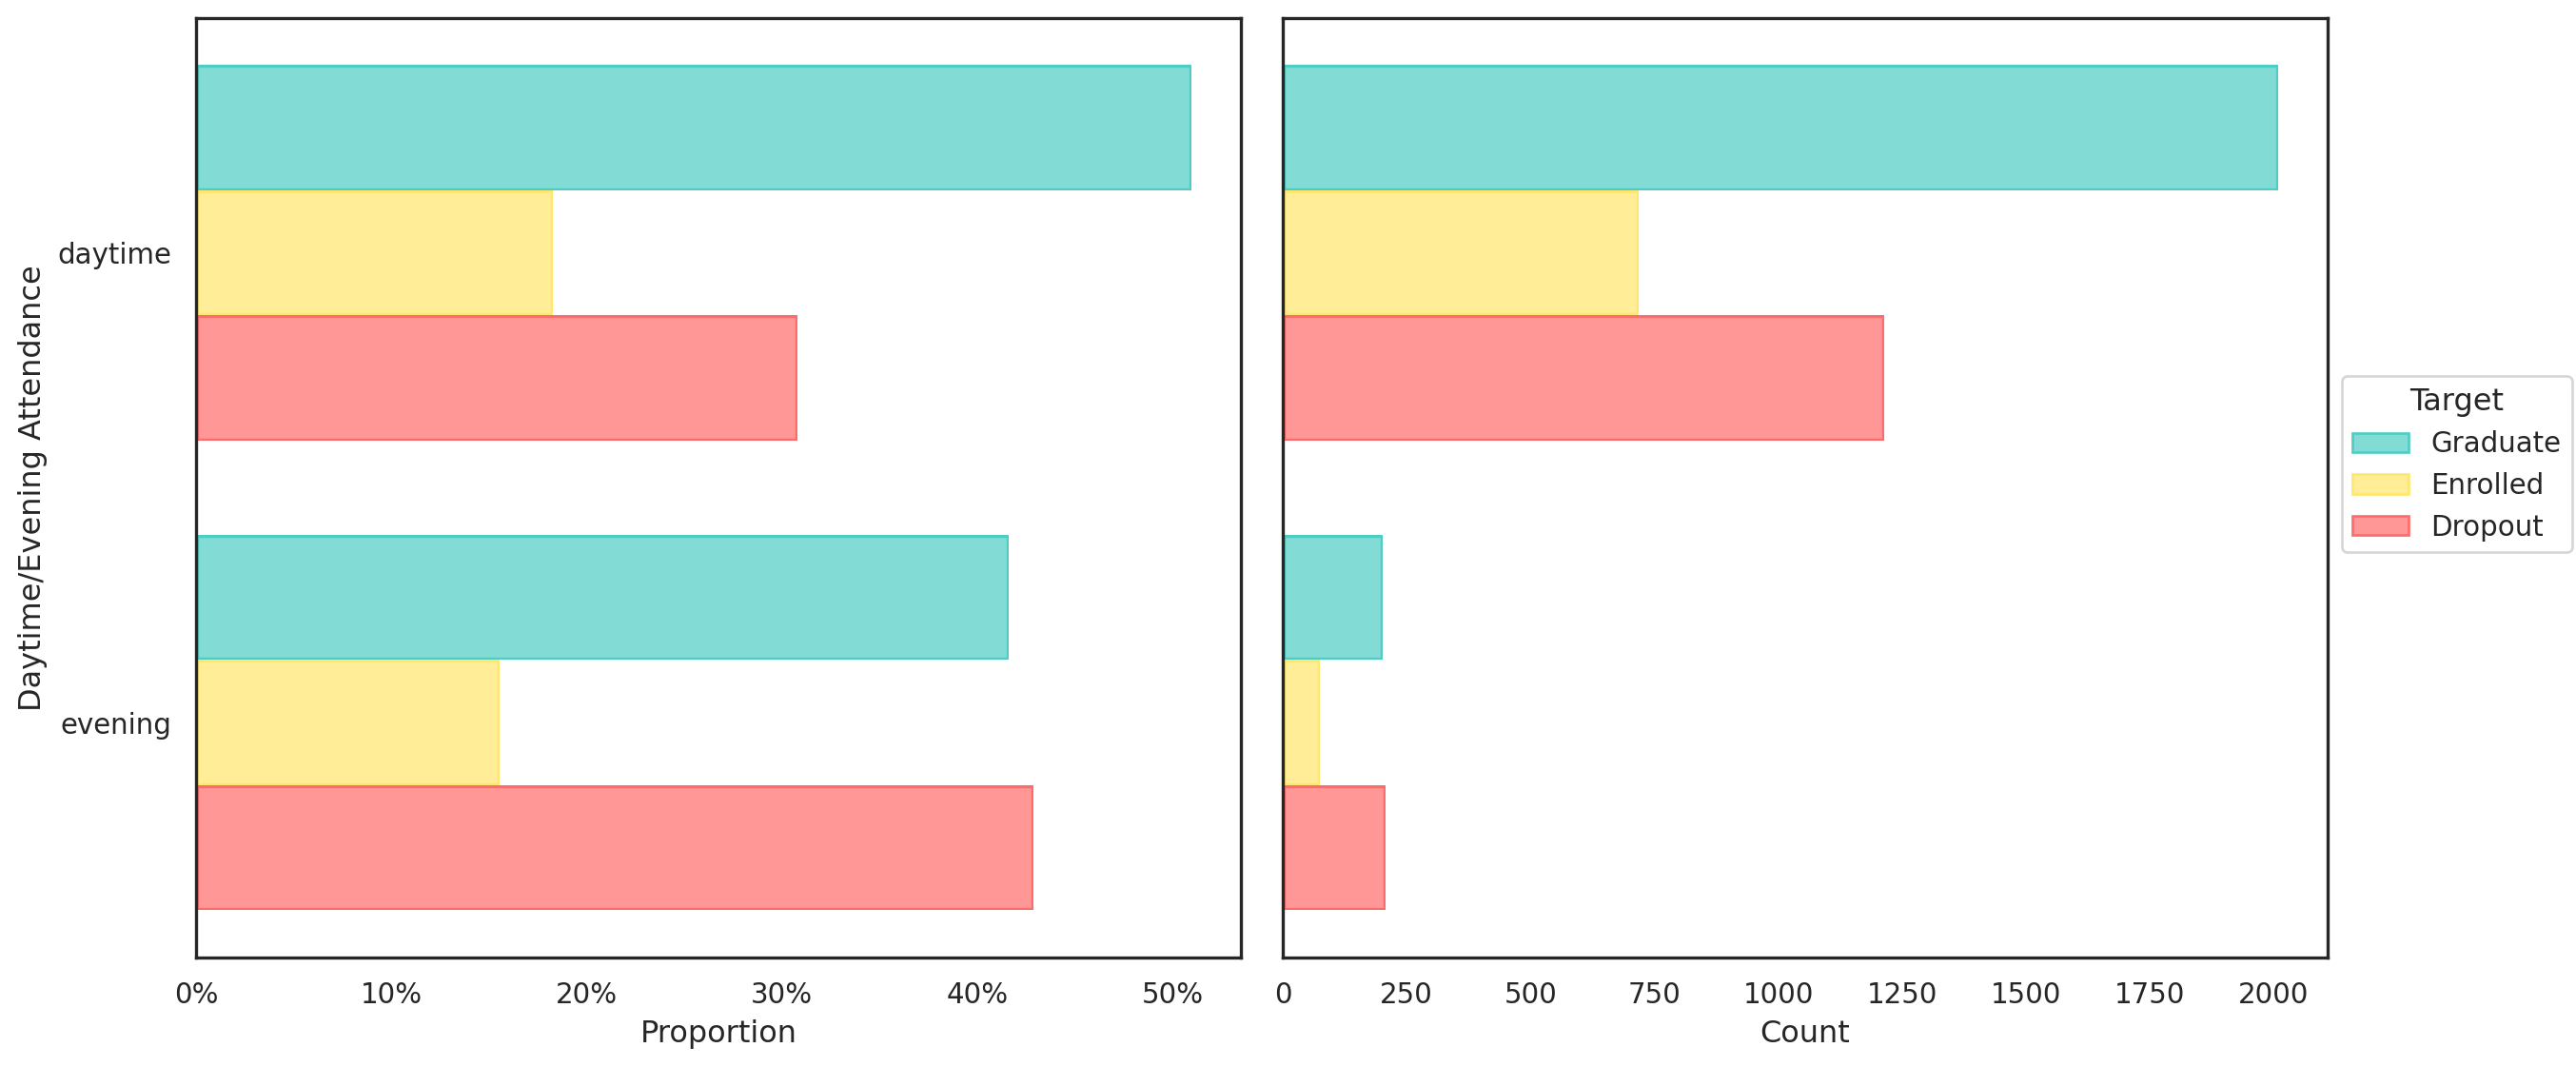

In [13]:
students.pipe(plot_proportions, "daytime/evening_attendance")

Daytime students are more likely to graduate, the majority of the evening students dropout (more than 40%)

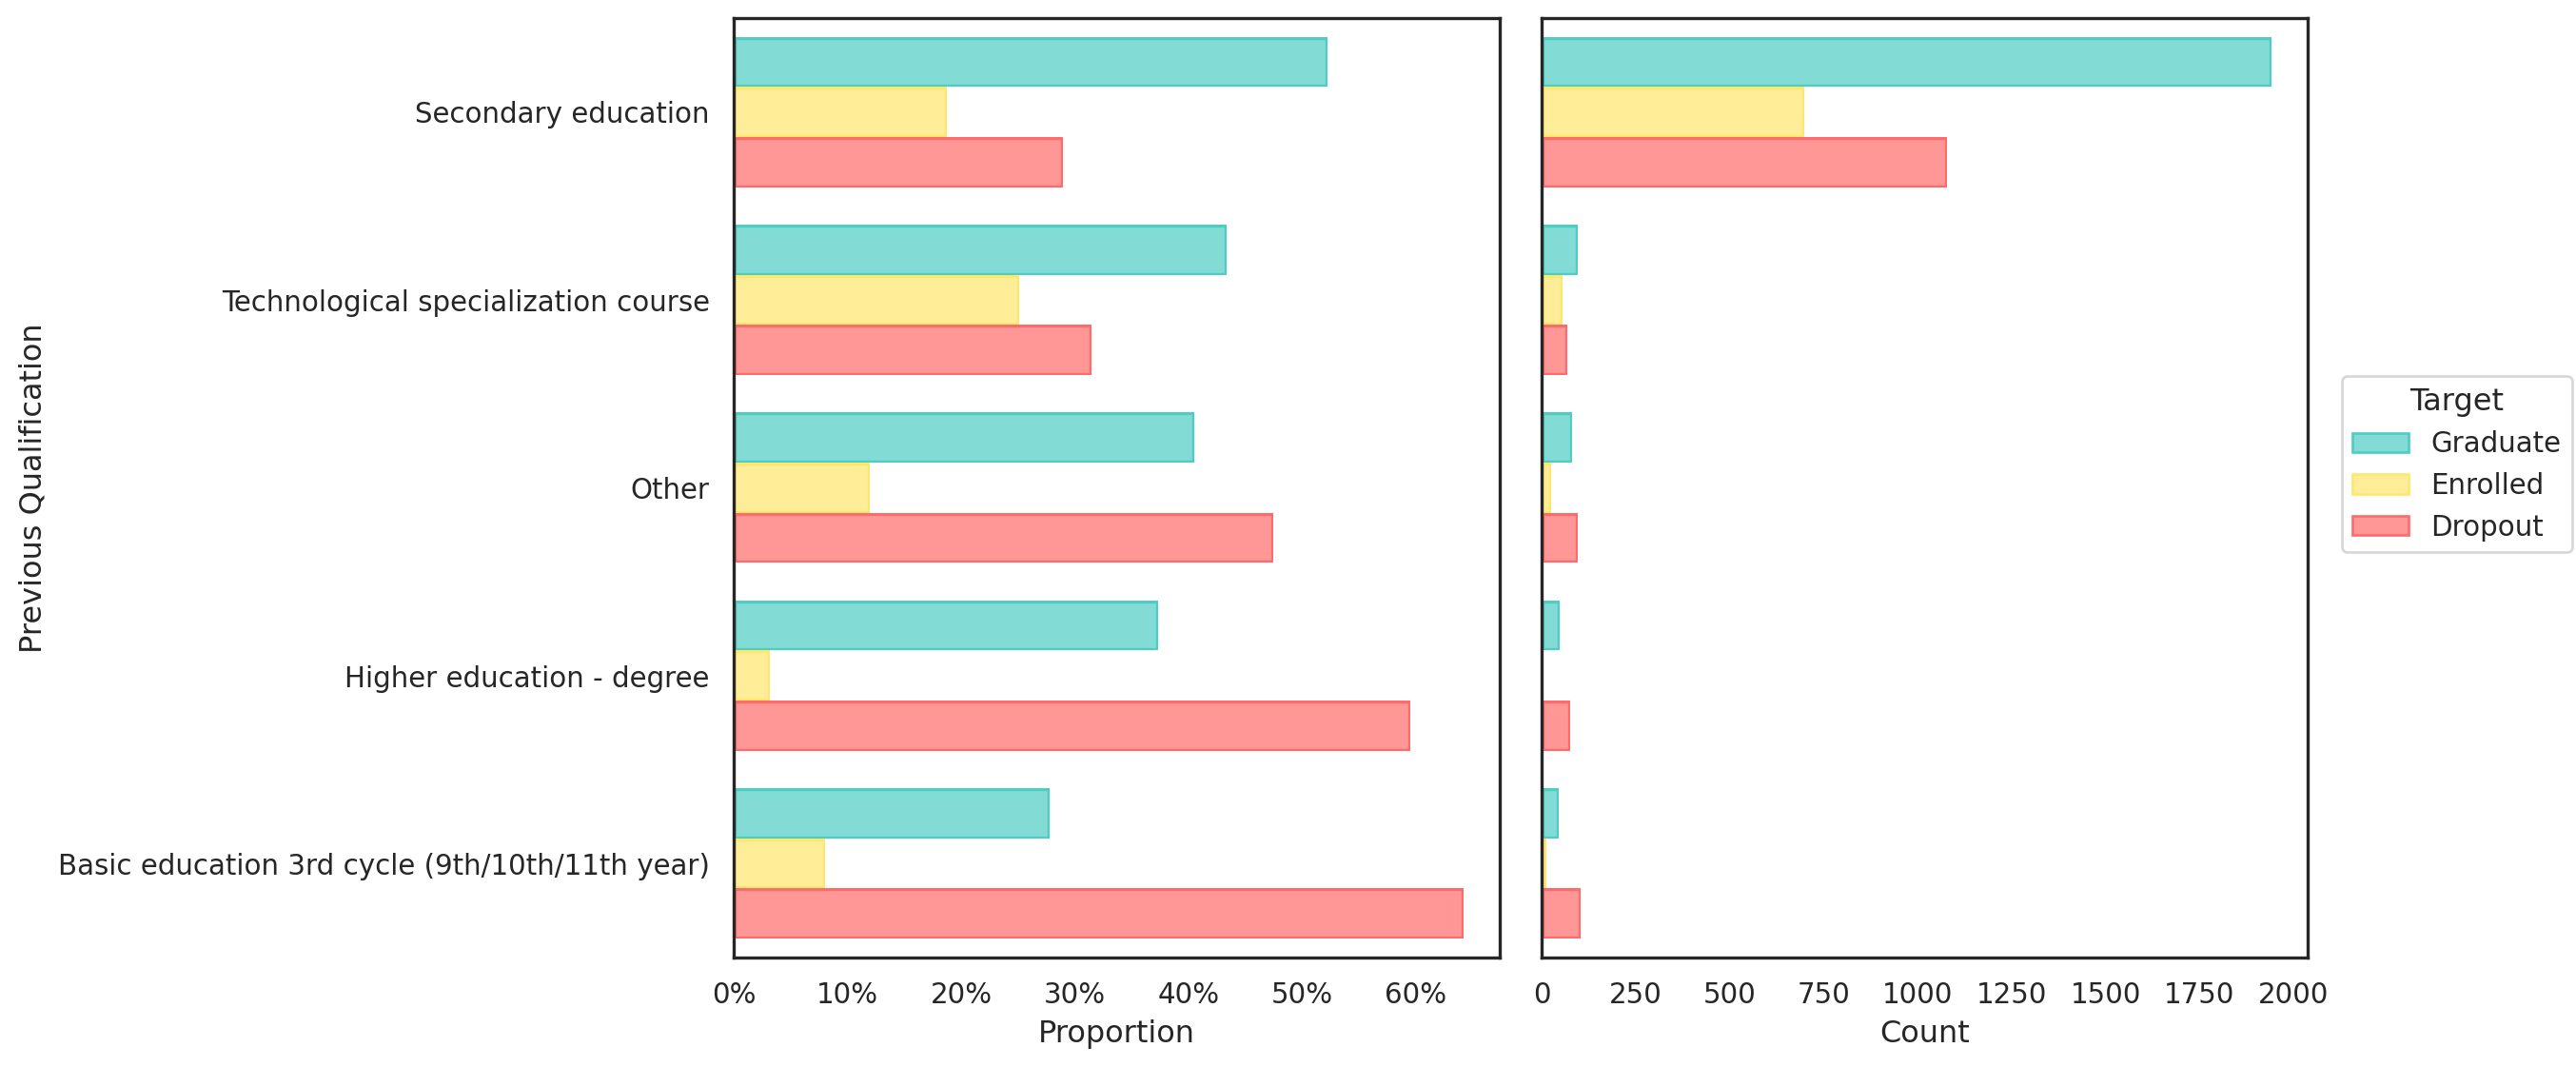

In [14]:
(students
 .assign(previous_qualification = lambda x: fct_lump(x.previous_qualification, 4))
 .pipe(plot_proportions, "previous_qualification")
)

Most of the students have a secondary education degree, so there is not a lot of data in the other categories, but the dropout rates in this rare categories is really high (~ 60%). Is it by chance or this could be a good predictor?

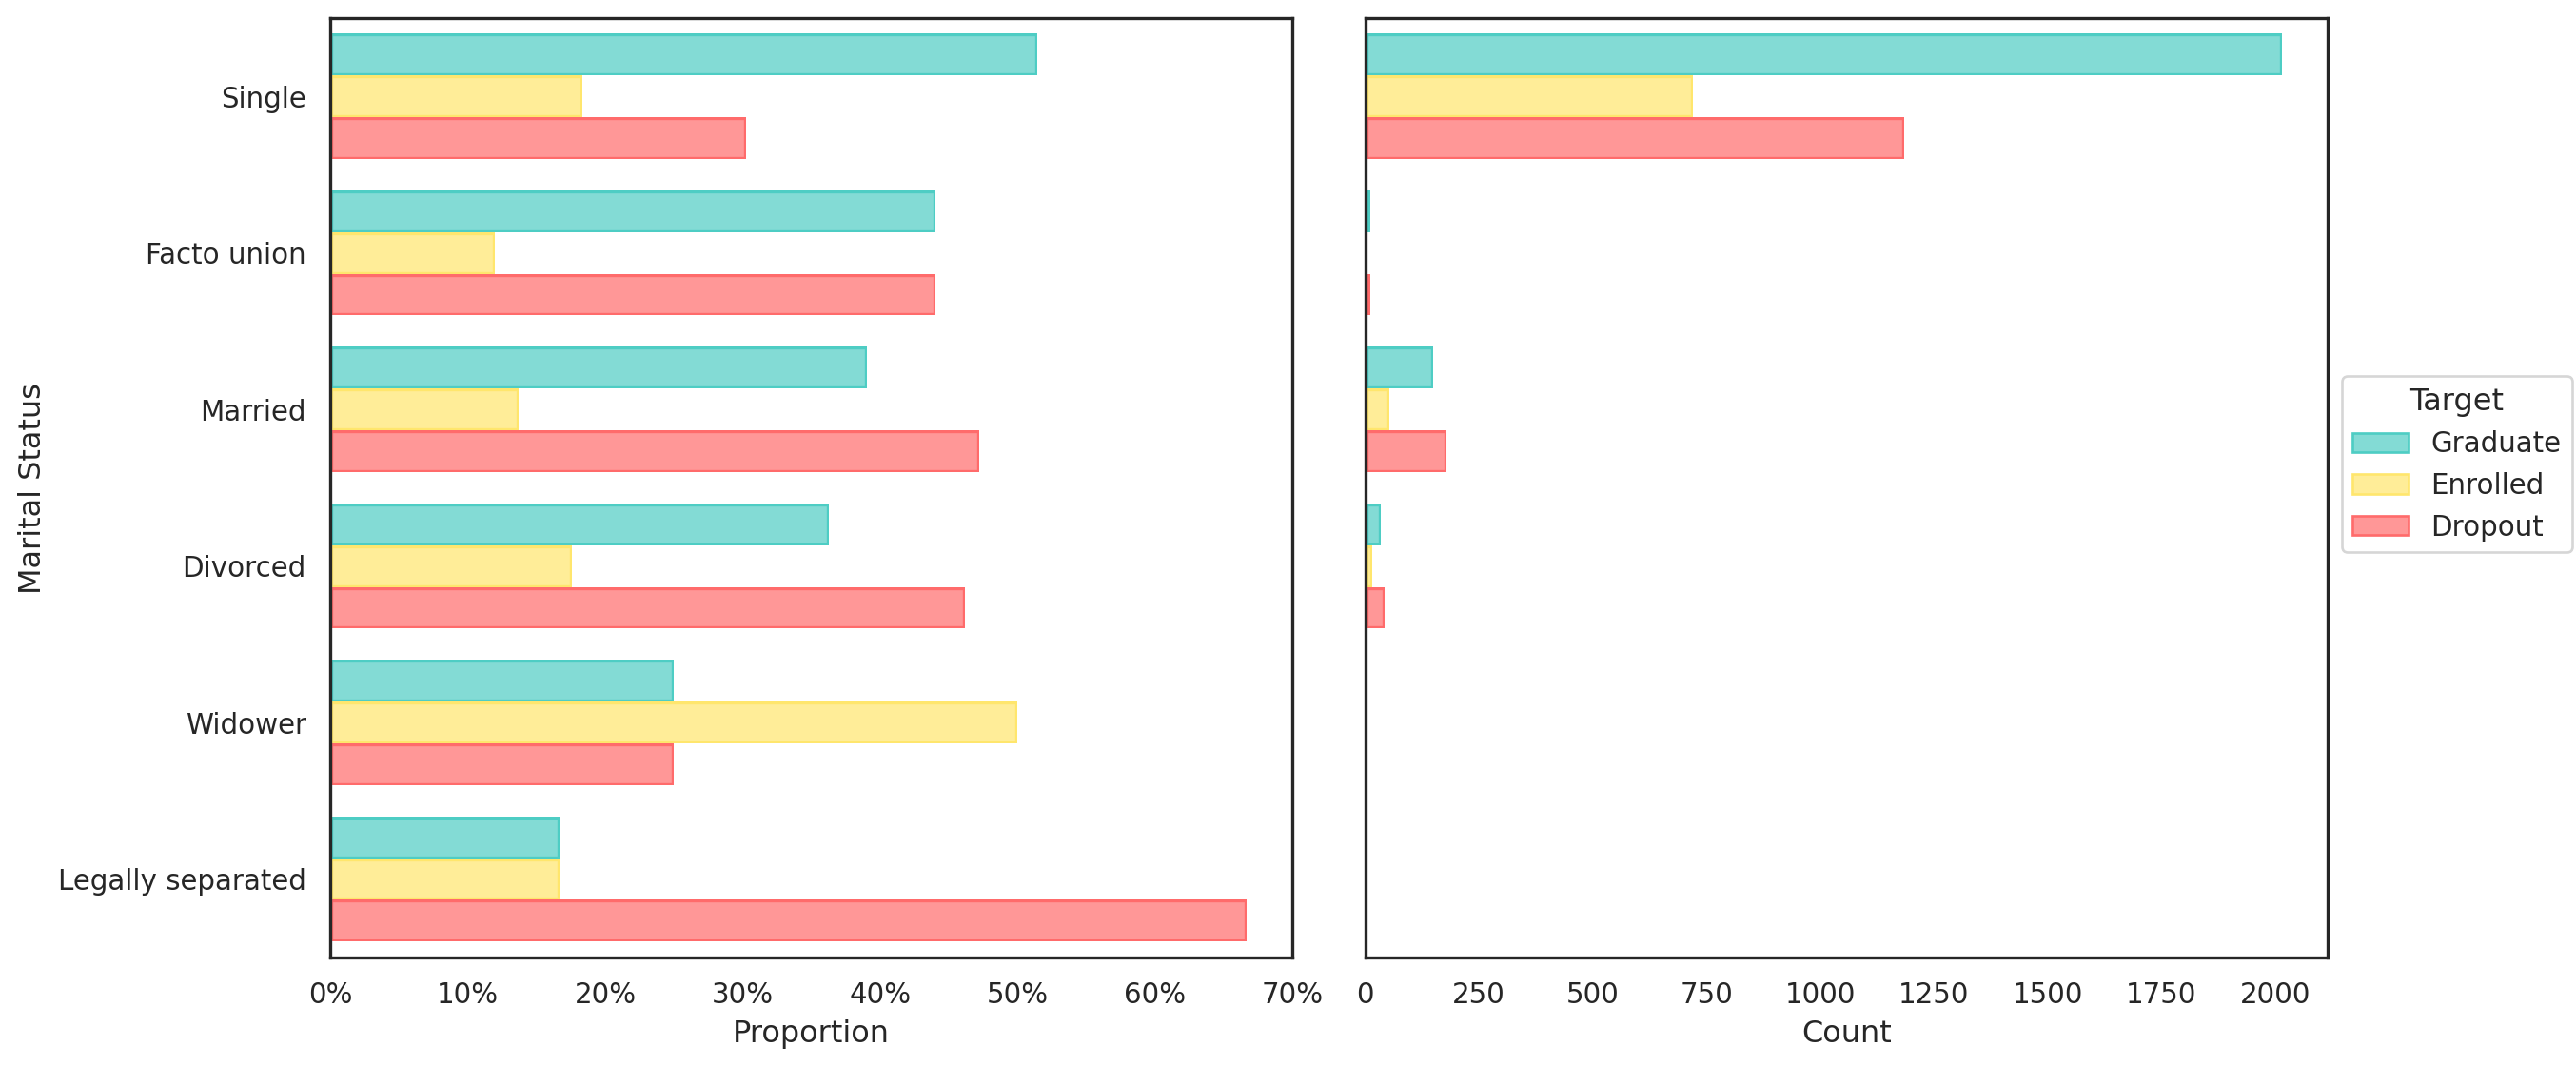

In [15]:
students.pipe(plot_proportions, "marital_status")

The big majority of the students are single (more than 80% of the total)

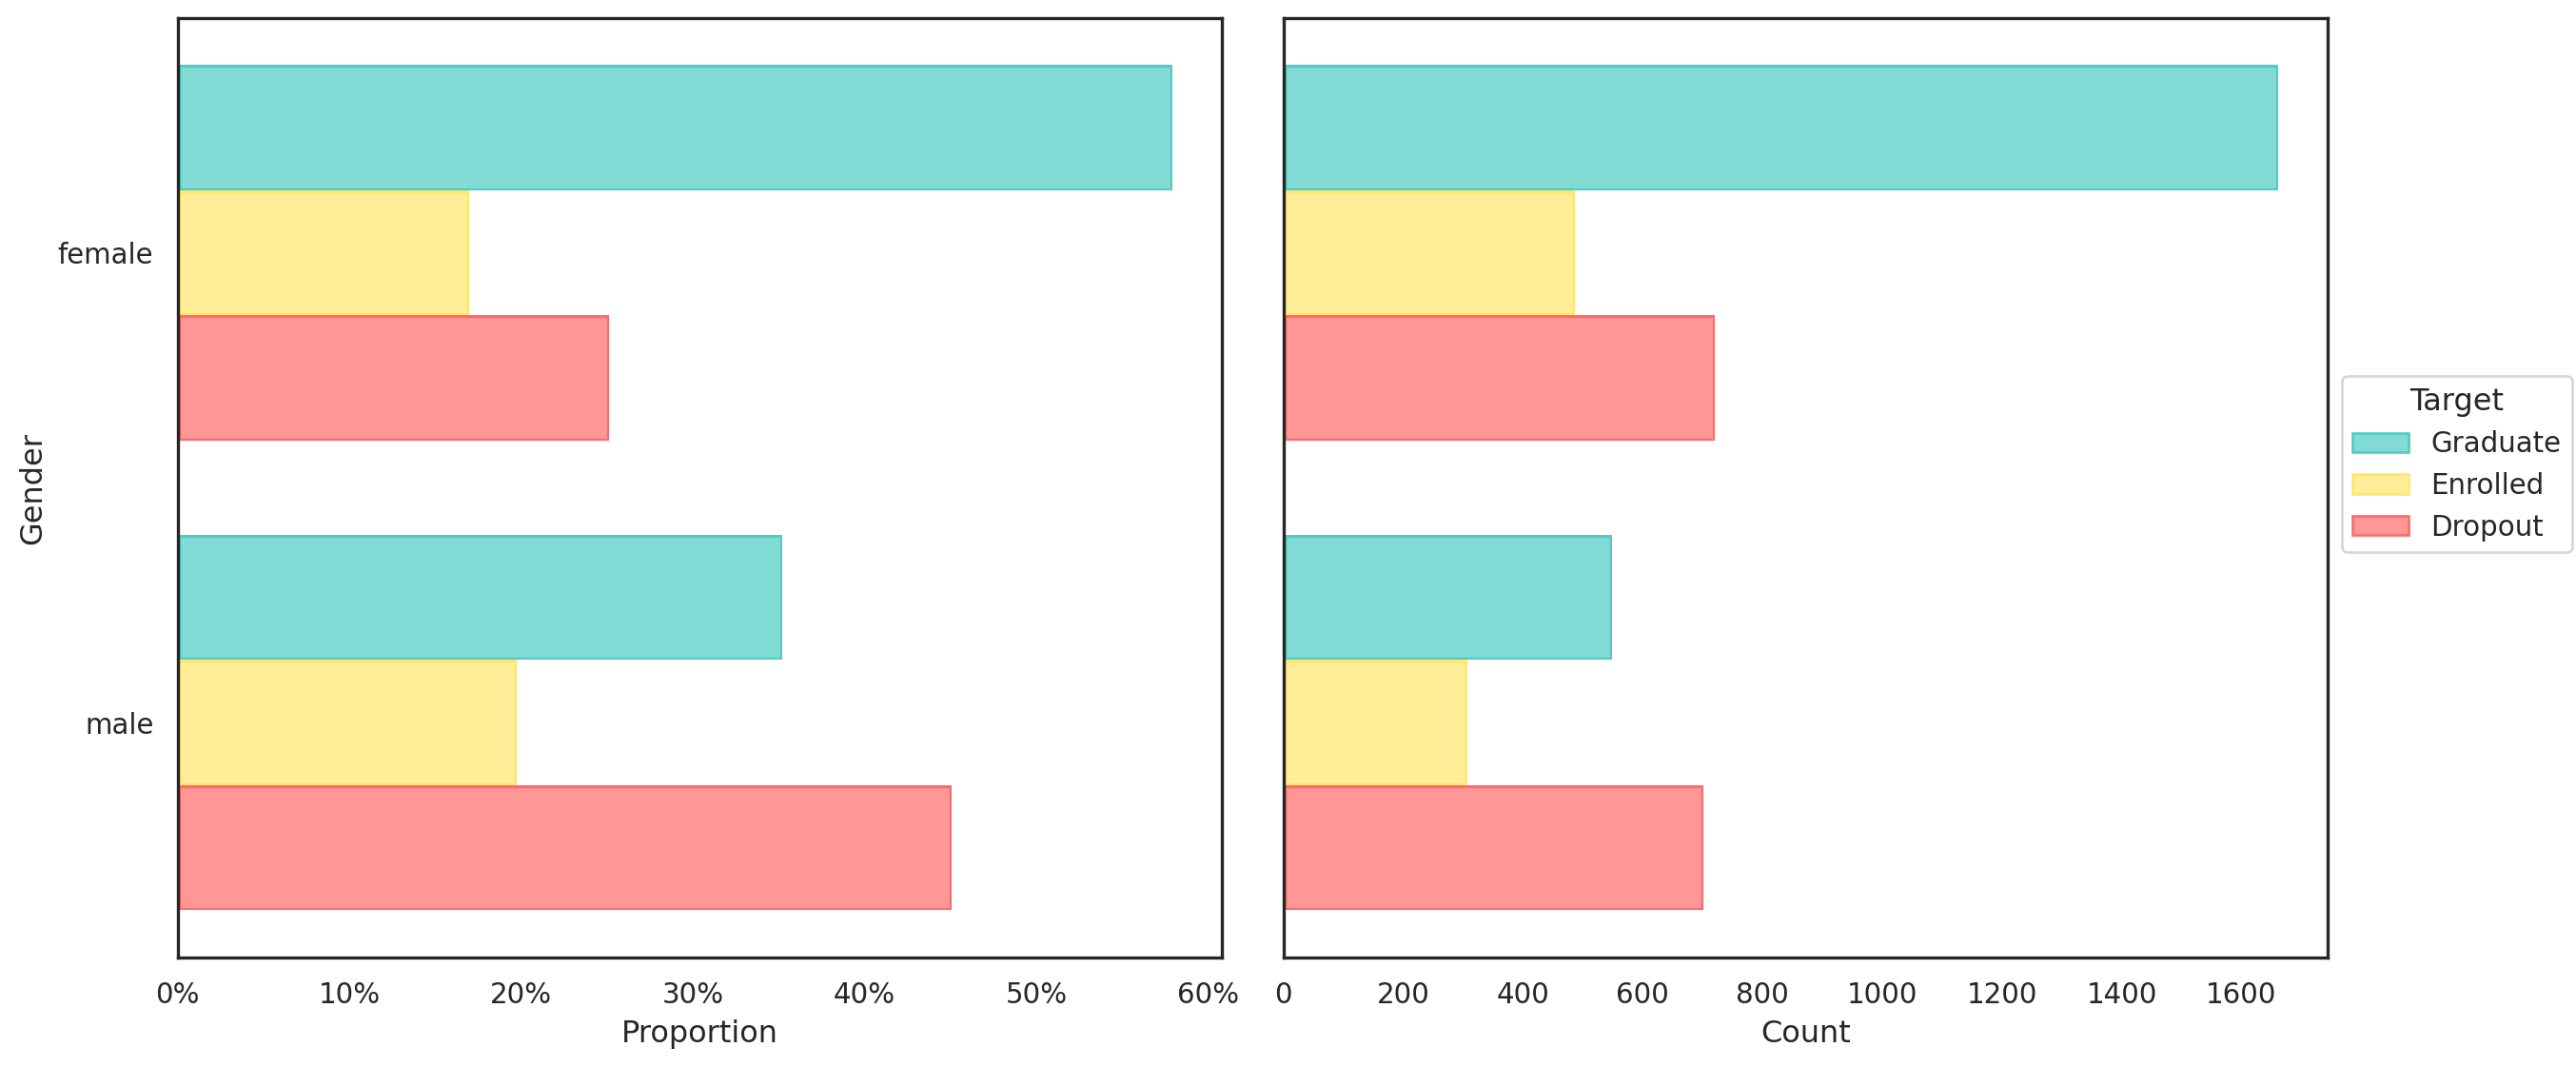

In [16]:
students.pipe(plot_proportions, "gender")

Big difference between men and women in graduations rate. Most of the men dropout whilst most of the women graduate. Is this a gender capacity difference? Are women more studious than men? or is there another [confounding variable](https://en.wikipedia.org/wiki/Confounding) affecting the outcome? For instance, in STEM (Science, technology, engineering, and mathematics) courses the majority of the students are men, and we saw before that these courses have the major dropout rates in contrast to social disciplines. I will analyze this deeper later.

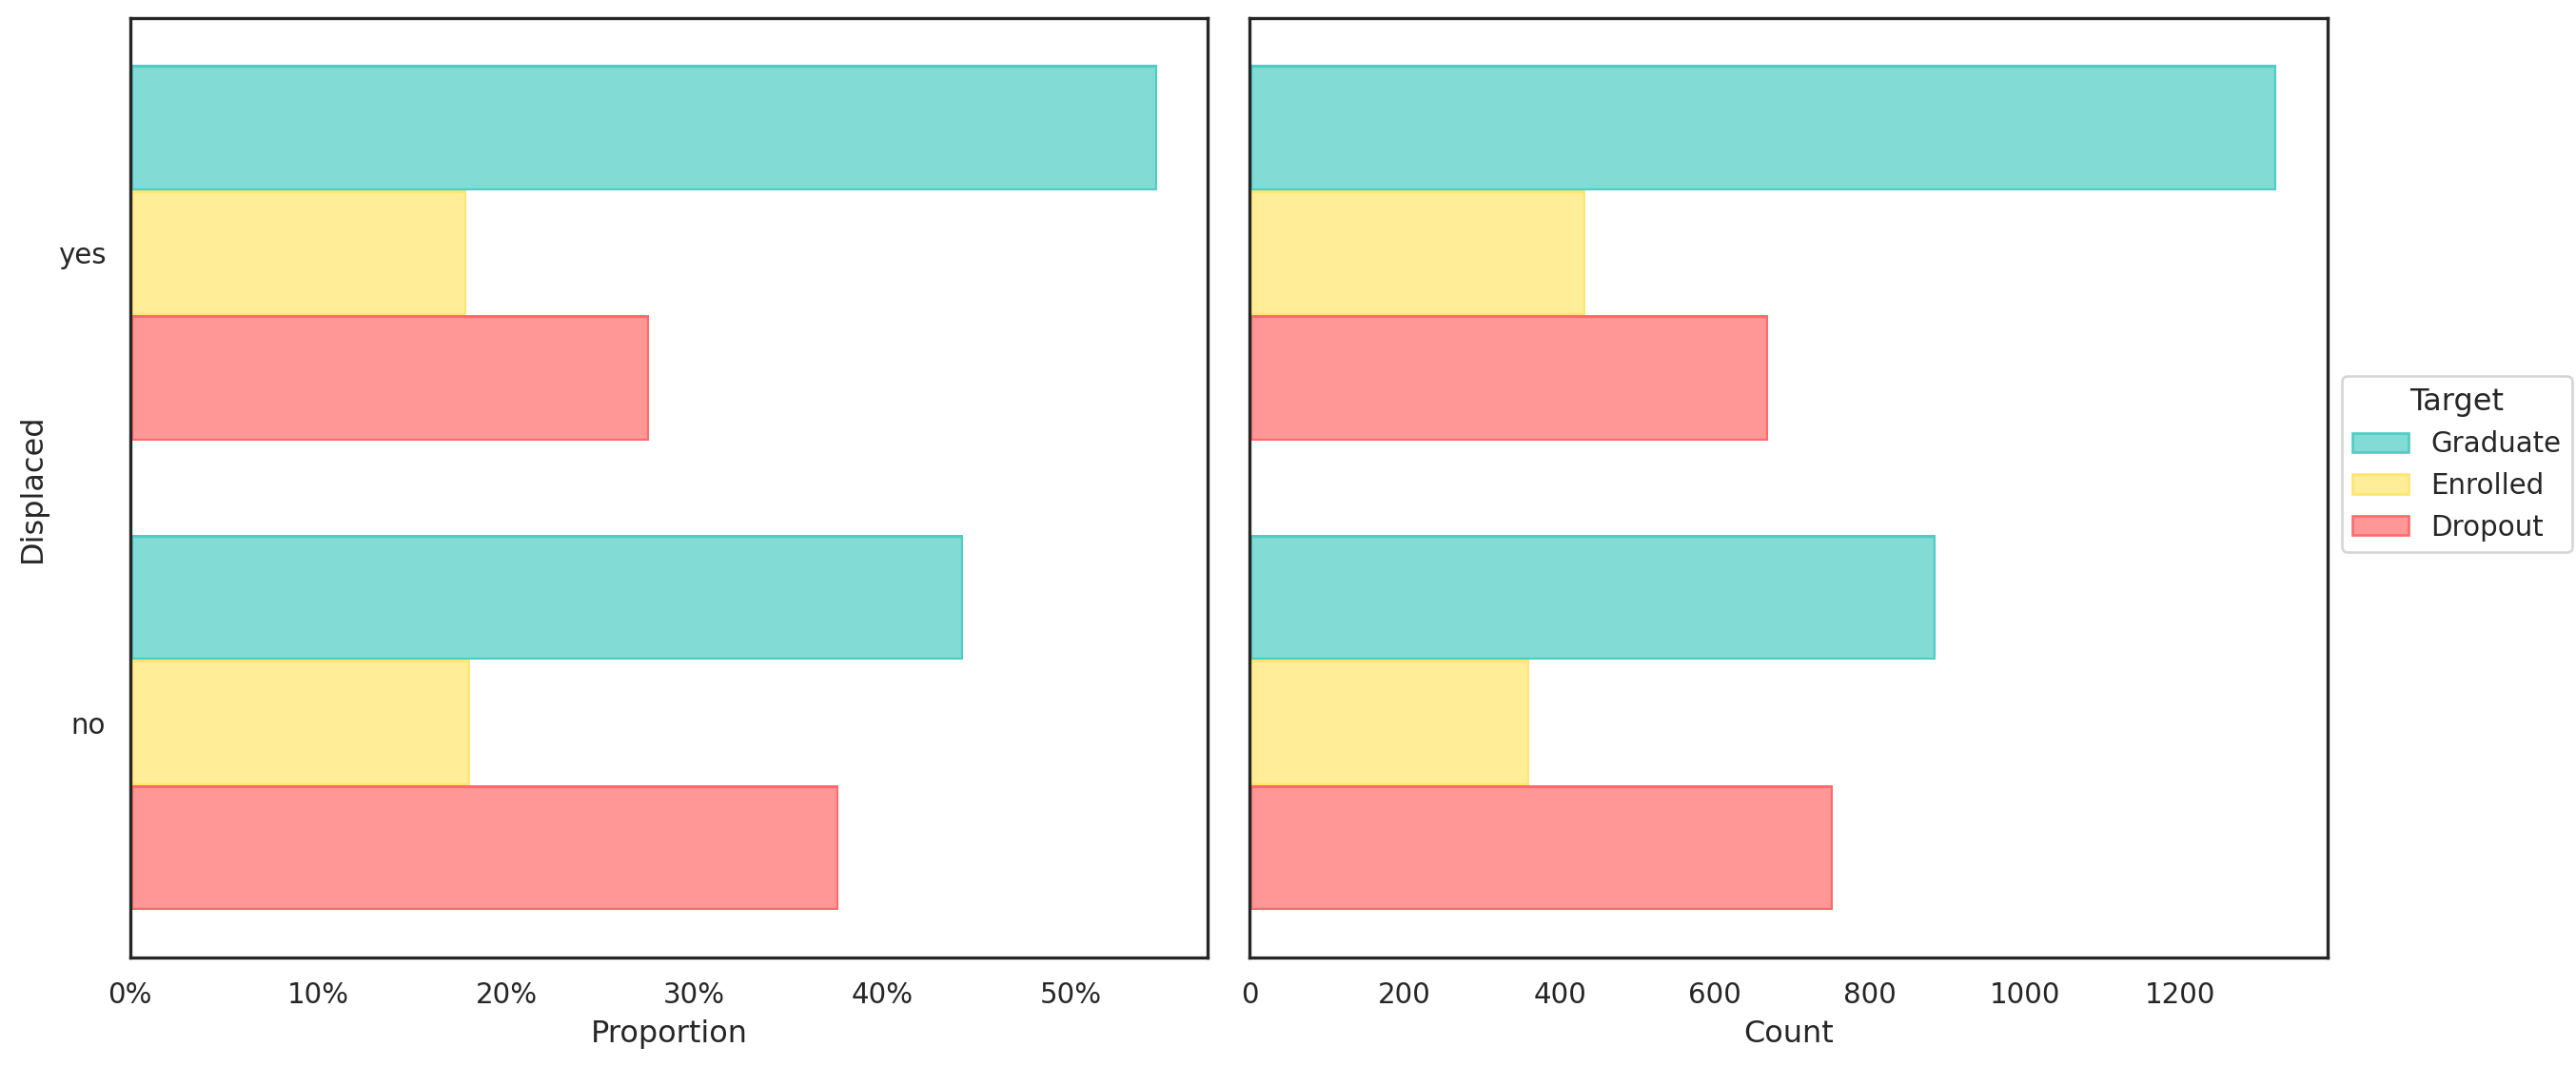

In [17]:
students.pipe(plot_proportions, "displaced")

Those who displaced are more likely to graduate and less likely to dropout

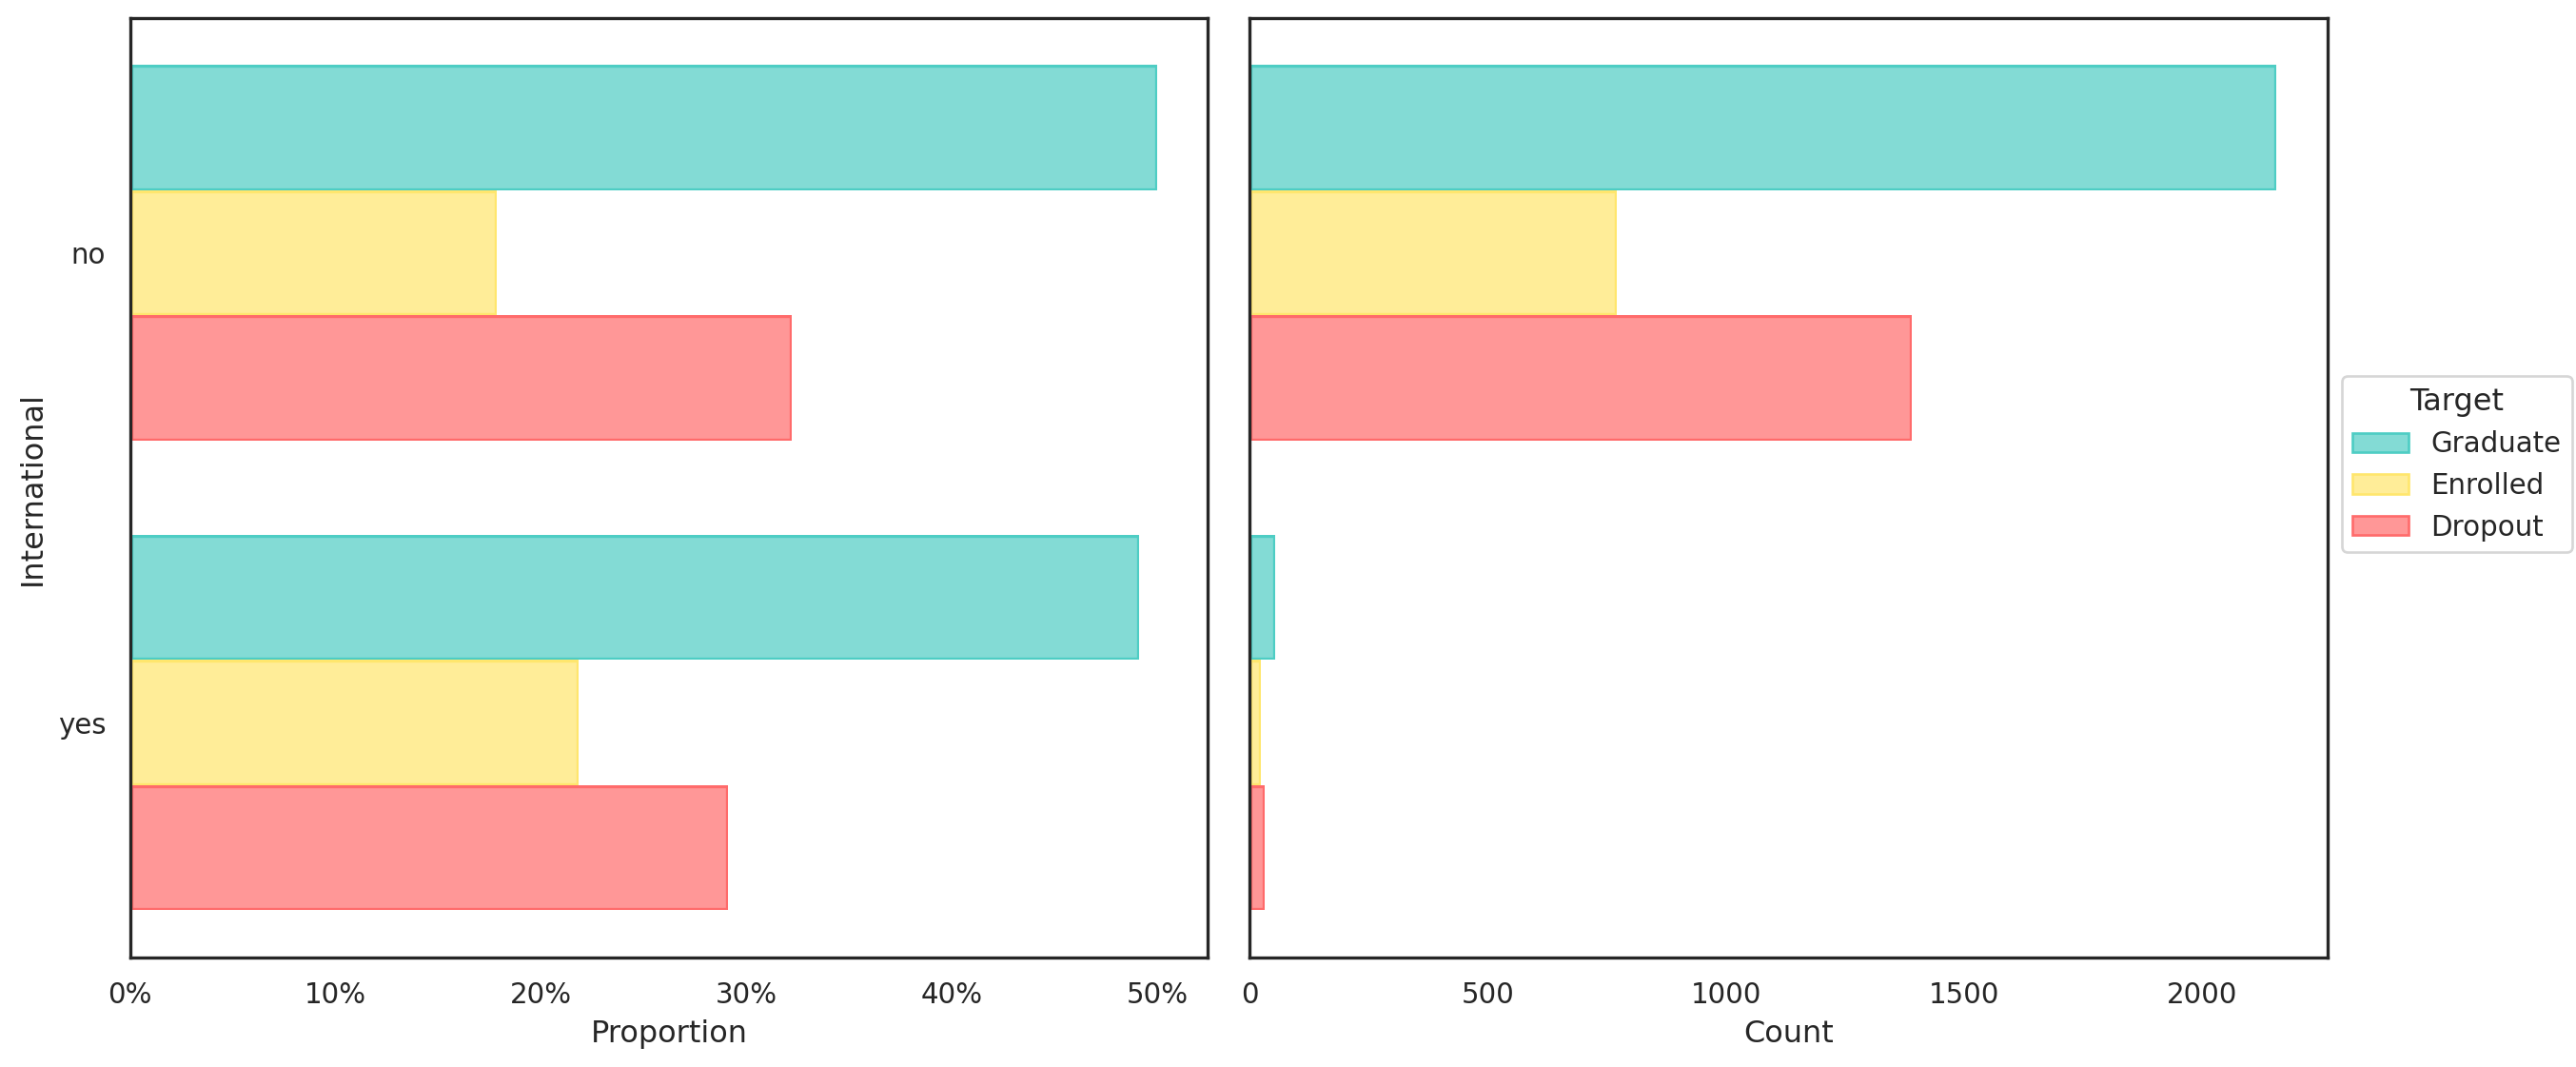

In [18]:
students.pipe(plot_proportions, "international")

In [52]:
students.value_counts("international", normalize=True)

international
no     0.975136
yes    0.024864
dtype: float64

International students only account for 2.5% of the total data, the proportion within each group seems to be the same, that's why this one is probably not a good predictor.

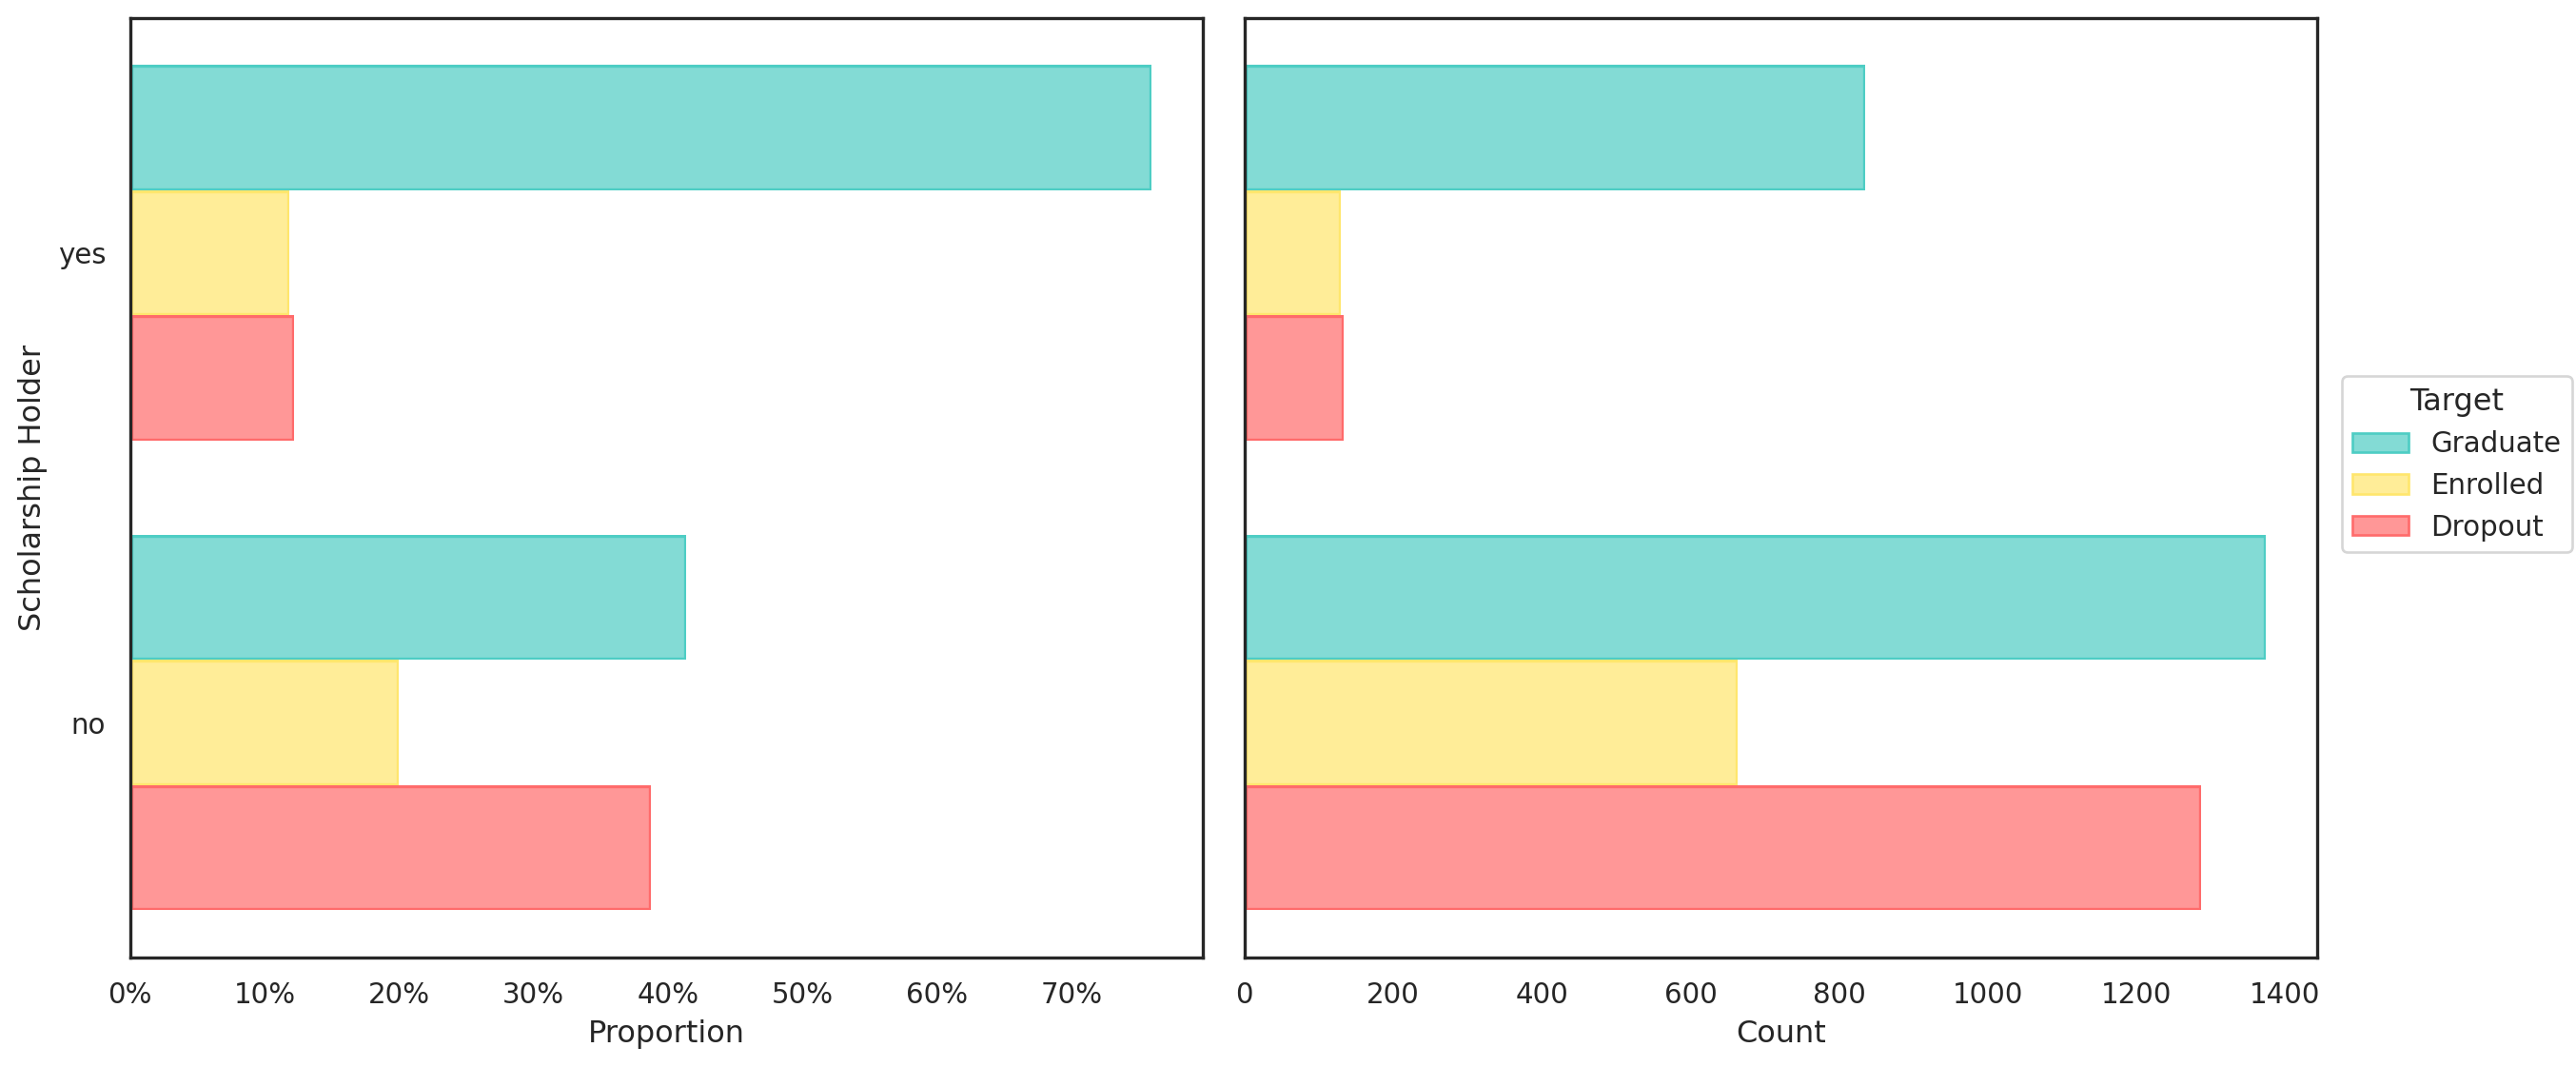

In [19]:
students.pipe(plot_proportions, "scholarship_holder")

Wow, looks like scholarships are a great predictor of graduation, but correlation is not causation. Are scholarships making students more likely to graduate or is it that students that get scholarships are those with better grades and that is causing the higher graduation rate? I will dig up into this subject later

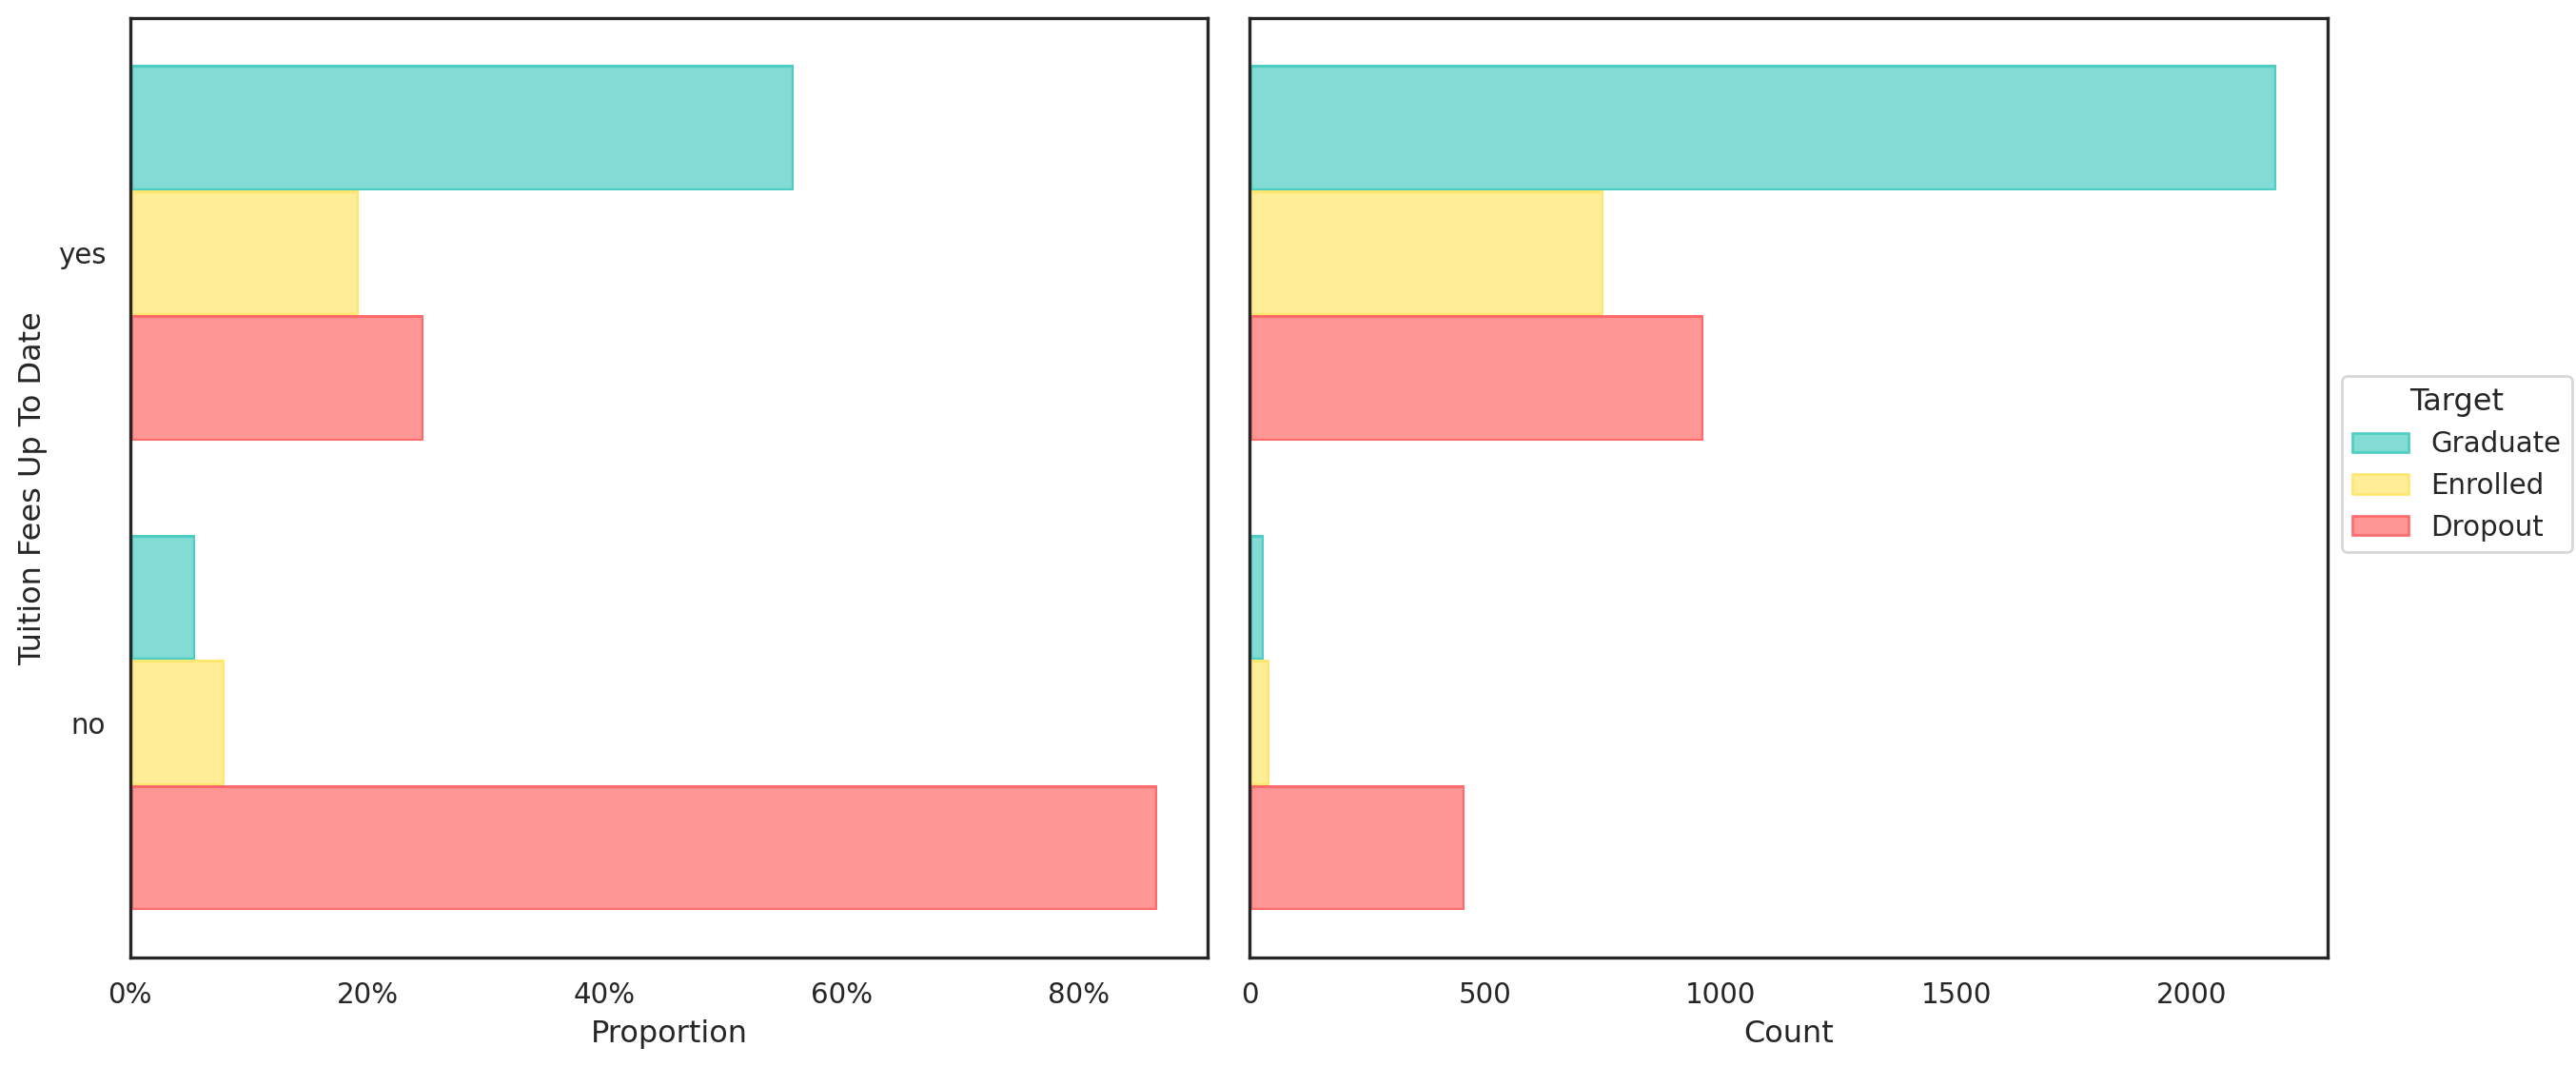

In [20]:
students.pipe(plot_proportions, "tuition_fees_up_to_date")

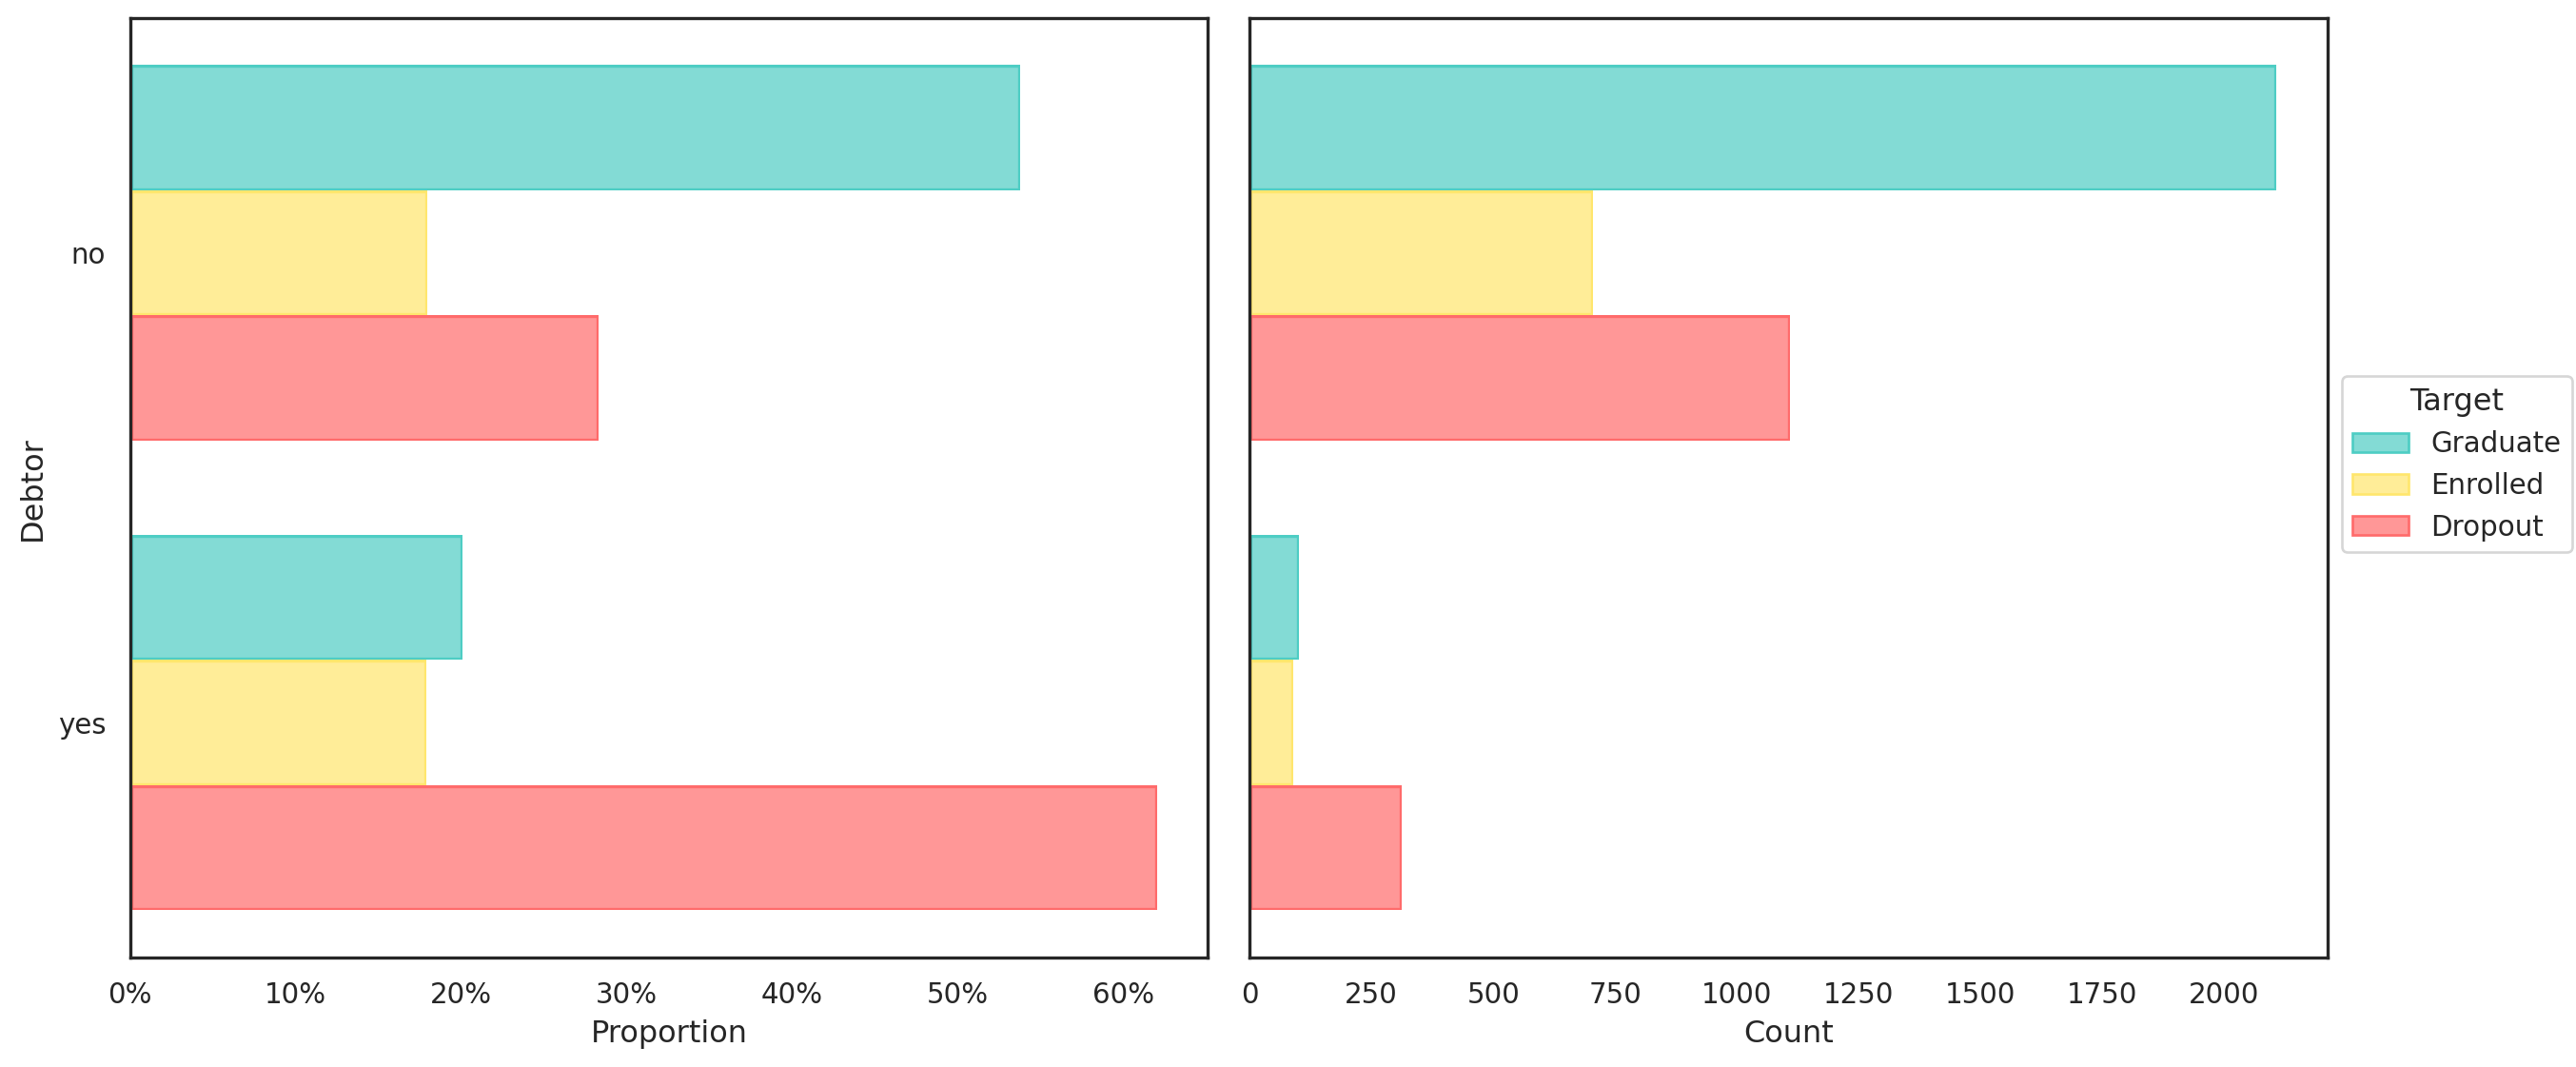

In [59]:
students.pipe(plot_proportions, "debtor")

Probably "tuition fees up to date" and "debtor" are correlated, since both should be measuring a similar variable

In [85]:
pd.crosstab(students.debtor, students.tuition_fees_up_to_date).style.background_gradient(axis = None, cmap = "Purples")

Those who don't have their tuition fee up to date and/or are debtors are really likely of dropout, even though these two variables are not highly correlated. As seen in the last table, most students (82%) are not debtors and have their tuition up to date, the rest of them are almost equally divided between the other categories. This makes sense, once you know you will leave, you stop paying. Probably this is a great indicator for the university, those who stop paying their tuition and/or are debtors are really likely to dropout. In these cases, they might want to follow up those cases and check what is happening.

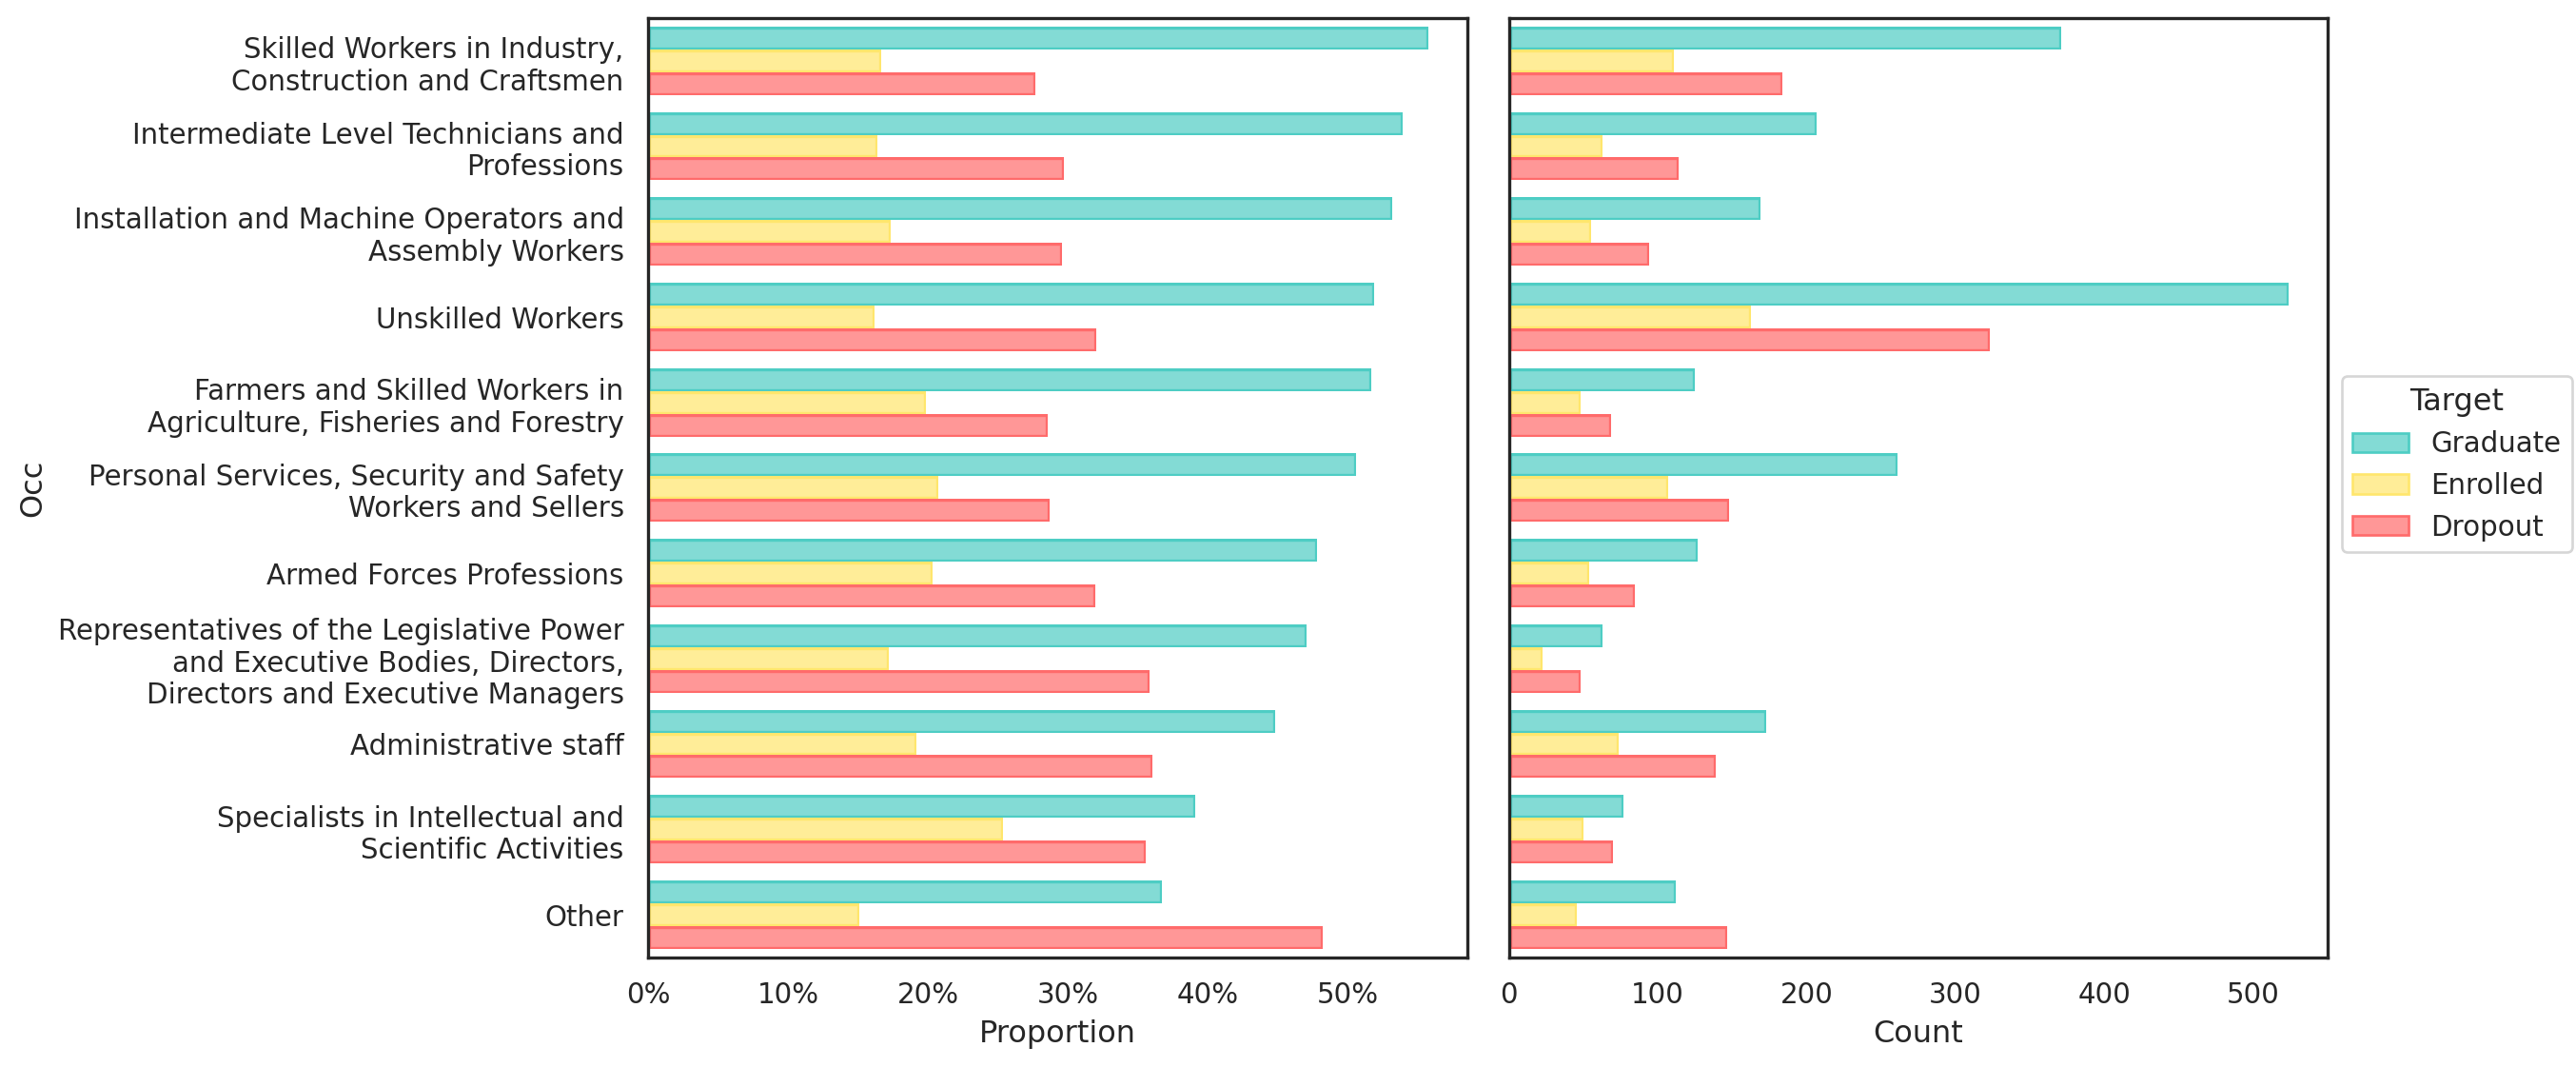

In [21]:
from textwrap import wrap
(students
 .assign(occ = lambda x: fct_lump(x["father's_occupation"], 10))
 .assign(occ = lambda x: x.occ.apply(lambda y: "\n".join(wrap(y, width=40, expand_tabs=False))))
 .pipe(plot_proportions, "occ")
)

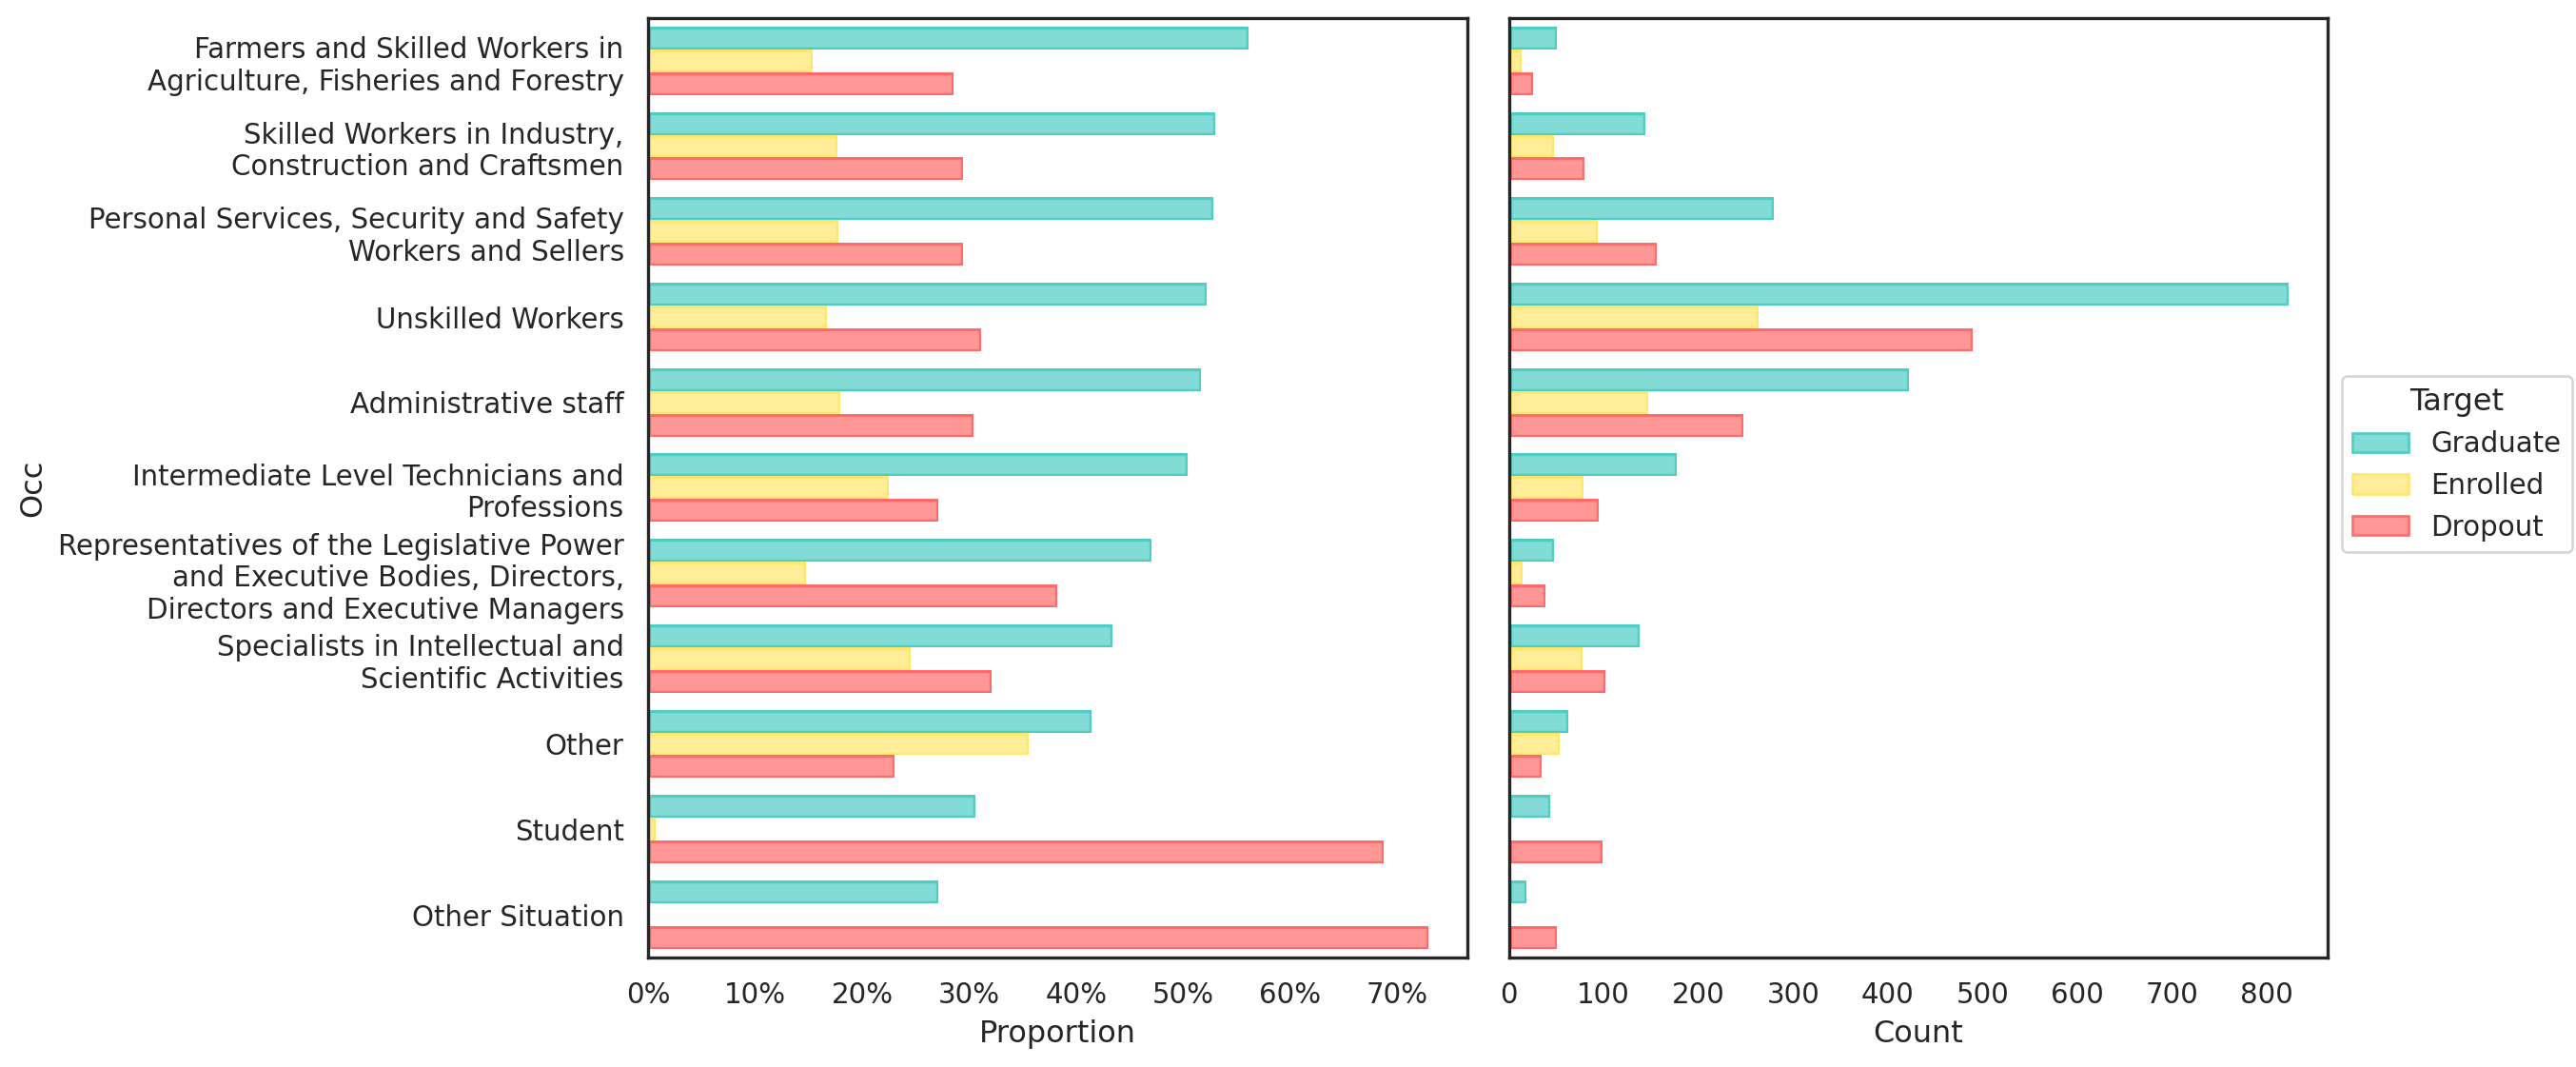

In [22]:
from textwrap import wrap
(students
 .assign(occ = lambda x: fct_lump(x["mother's_occupation"], 10))
 .assign(occ = lambda x: x.occ.apply(lambda y: "\n".join(wrap(y, width=40, expand_tabs=False))))
 .pipe(plot_proportions, "occ")
)

In [22]:
students

marital_status  application_mode  application_order  course  \
0                NaN               NaN                  5     NaN   
1                NaN               NaN                  1     NaN   
2                NaN               NaN                  5     NaN   
3                NaN               NaN                  2     NaN   
4                NaN               NaN                  1     NaN   
...              ...               ...                ...     ...   
4419             NaN               NaN                  6     NaN   
4420             NaN               NaN                  2     NaN   
4421             NaN               NaN                  1     NaN   
4422             NaN               NaN                  1     NaN   
4423             NaN               NaN                  1     NaN   

      daytime/evening_attendance  previous_qualification  nationality  \
0                            NaN                     NaN          NaN   
1                            NaN                     NaN          NaN   
2                            NaN                     NaN          NaN   
3                            NaN                     NaN          NaN   
4                            NaN                     NaN          NaN   
...                          ...                     ...          ...   
4419                         NaN                     NaN          NaN   
4420                         NaN                     NaN          NaN   
4421                         NaN                     NaN          NaN   
4422                         NaN                     NaN          NaN   
4423                         NaN                     NaN          NaN   

      mother's_qualification  father's_qualification  mother's_occupation  \
0                        NaN                     NaN                  NaN   
1                        NaN                     NaN                  NaN   
2                        NaN                     NaN                  NaN   
3                        NaN                     NaN                  NaN   
4                        NaN                     NaN                  NaN   
...                      ...                     ...                  ...   
4419                     NaN                     NaN                  NaN   
4420                     NaN                     NaN                  NaN   
4421                     NaN                     NaN                  NaN   
4422                     NaN                     NaN                  NaN   
4423                     NaN                     NaN                  NaN   

      ...  curricular_units_2nd_sem_(credited)  \
0     ...                                    0   
1     ...                                    0   
2     ...                                    0   
3     ...                                    0   
4     ...                                    0   
...   ...                                  ...   
4419  ...                                    0   
4420  ...                                    0   
4421  ...                                    0   
4422  ...                                    0   
4423  ...                                    0   

      curricular_units_2nd_sem_(enrolled)  \
0                                       0   
1                                       6   
2                                       6   
3                                       6   
4                                       6   
...                                   ...   
4419                                    6   
4420                                    6   
4421                                    8   
4422                                    5   
4423                                    6   

      curricular_units_2nd_sem_(evaluations)  \
0                                          0   
1                                          6   
2                                          0   
3                                        

In [14]:
parents_occupation = pd.concat(
    [students["mother's_occupation"], students["father's_occupation"]]
)
parents_occupation.value_counts().head(20)

Series([], dtype: int64)

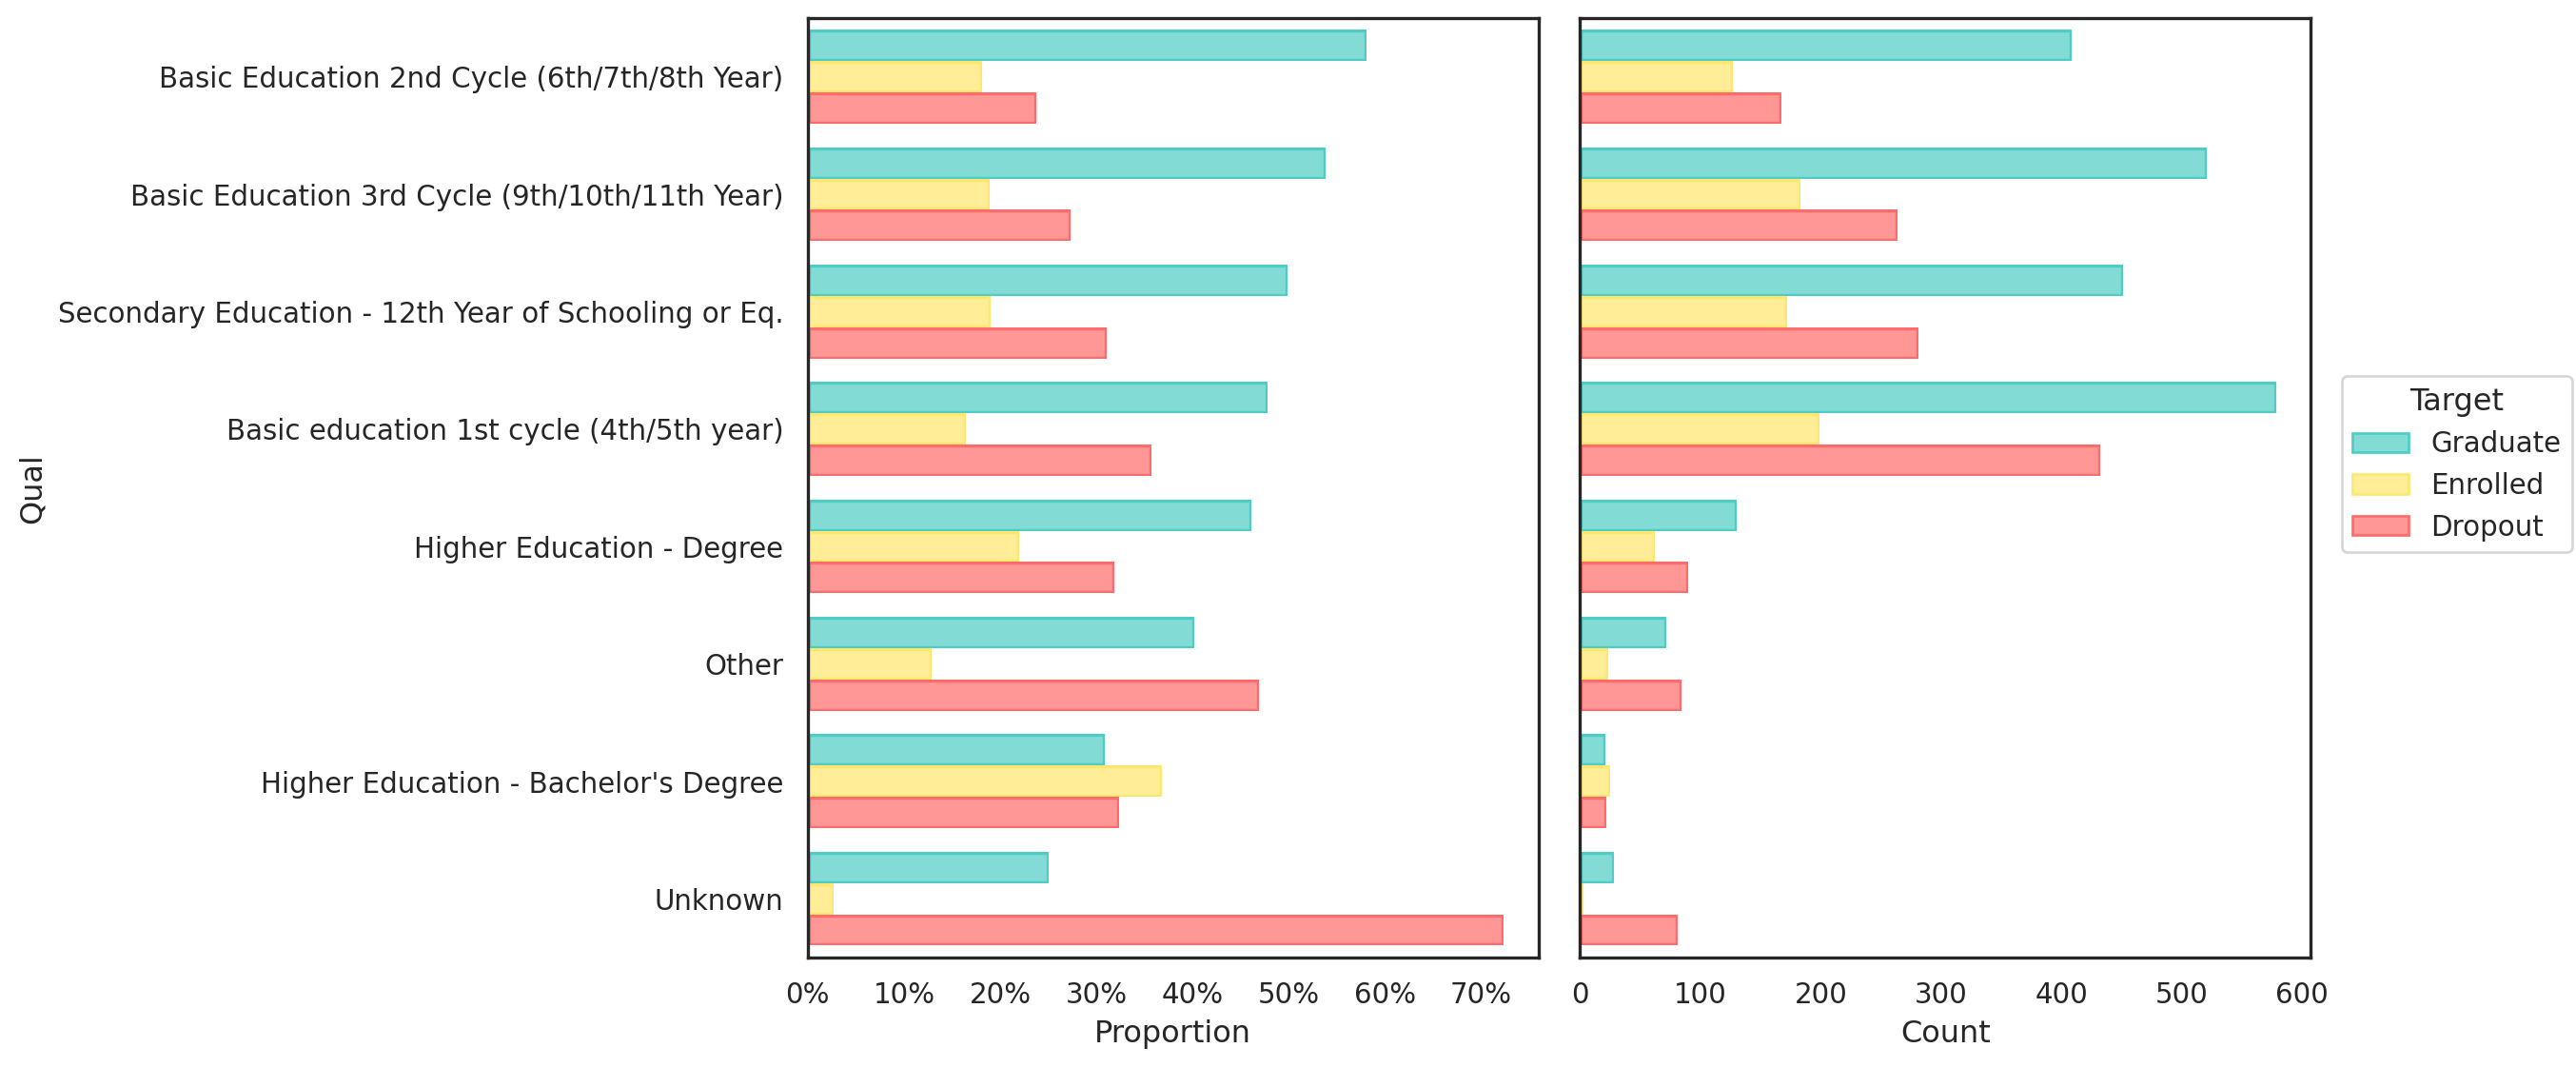

In [24]:
students.assign(qual = lambda x:fct_lump(x["father's_qualification"],7)).pipe(plot_proportions, "qual")

In [25]:
parents_qualification = pd.concat([students["mother\'s_qualification"], students["father\'s_qualification"]])
parents_qualification.value_counts().head(15)

Secondary Education - 12th Year of Schooling or Eq.    1973
Basic education 1st cycle (4th/5th year)               1213
General Course of Administration and Commerce          1010
Basic Education 3rd Cycle (9th/10th/11th Year)          969
General commerce course                                 954
Higher Education - Degree                               720
Basic Education 2nd Cycle (6th/7th/8th Year)            706
Supplementary Accounting and Administration             563
Higher Education - Bachelor's Degree                    151
2nd cycle of the general high school course             131
Unknown                                                 120
Higher Education - Master's                              88
Other - 11th Year of Schooling                           80
Higher Education - Doctorate                             39
Technological specialization course                      21
dtype: int64

It doesn't seems like the level of education of the parents or their job makes great difference in their children studies success. There seems to be a little negative correlation between success in studies and parents salaries and qualifications. Maybe this occurs because students with higher income parents are more likely to go to high level universities, and these are harder to approve? I 

In [12]:
education_map = {
    "Higher Education": "Higher Education",
    "Secondary Education|12th": "Secondary Education",
    "Basic education 1st cycle|4th|5th": "Basic education 1st cycle",
    "Basic Education 3rd Cycle|9th|10th|11th": "Basic Education 3rd Cycle",
    "Basic Education 2nd Cycle|6th|7th|8th": "Basic Education 2nd Cycle",
    "Unknown|Can't read": "Unknown",
    "2nd cycle of the general high school": "Basic Education 3rd Cycle",
    "course|Supplementary": "Tertiary course",
}

education_order = [
    "Unknown",
    "Basic education 1st cycle",
    "Basic Education 2nd Cycle",
    "Basic Education 3rd Cycle",
    "Secondary Education",
    "Tertiary course",
    "Higher Education",
]

occupation_map = {
    "Unskilled":"Unskilled",
    "Administrative":"Administrative",
    "Skilled":"Skilled",
    "Technicians":"Technicians",
    "Specialists":"Specialists",
    "Operators"
}

In [11]:
import re
from functools import partial


def map_values(x, map_dict):
    try:
        return next(
            map_dict[k] for k in map_dict if re.search(k, x, flags=re.IGNORECASE)
        )
    except:
        return None


map_education = partial(map_values, map_dict=education_map)

students["father_qual_clean"] = students["father's_qualification"].map(map_education)

In [171]:
students["mother_qual_clean"] = students["mother's_qualification"].map(map_values)

In [173]:
students["mother_qual_clean"].value_counts()

Tertiary                     2532
Secondary Education          1077
Higher Education              595
Basic Education 3rd Cycle     180
Basic Education 2nd Cycle      13
Basic education 1st cycle      10
Can't read                      9
Unknown                         8
Name: mother_qual_clean, dtype: int64

In [174]:
students["father_qual_clean"].value_counts()

Basic education 1st cycle    1217
Basic Education 3rd Cycle    1016
Secondary Education           909
Basic Education 2nd Cycle     718
Higher Education              417
Unknown                       112
Tertiary                       33
Can't read                      2
Name: father_qual_clean, dtype: int64

In [176]:
students["mother's_qualification"].value_counts()

Secondary Education - 12th Year of Schooling or Eq.    1069
General Course of Administration and Commerce          1009
General commerce course                                 953
Supplementary Accounting and Administration             562
Higher Education - Degree                               438
2nd cycle of the general high school course             130
Higher Education - Bachelor's Degree                     83
Higher Education - Master's                              49
Other - 11th Year of Schooling                           42
Higher Education - Doctorate                             21
Can't read or write                                       9
12th Year of Schooling - Not Completed                    8
Unknown                                                   8
Can read without having a 4th year of schooling           6
Frequency of Higher Education                             4
Basic education 1st cycle (4th/5th year)                  4
Basic Education 2nd Cycle (6th/7th/8th Y

In [177]:
students["father's_qualification"].value_counts()

Basic education 1st cycle (4th/5th year)               1209
Basic Education 3rd Cycle (9th/10th/11th Year)          968
Secondary Education - 12th Year of Schooling or Eq.     904
Basic Education 2nd Cycle (6th/7th/8th Year)            702
Higher Education - Degree                               282
Unknown                                                 112
Higher Education - Bachelor's Degree                     68
Higher Education - Master's                              39
Other - 11th Year of Schooling                           38
Technological specialization course                      20
Higher Education - Doctorate                             18
7th Year (Old)                                           10
Can read without having a 4th year of schooling           8
12th Year of Schooling - Not Completed                    5
Higher education - degree (1st cycle)                     5
Technical-professional course                             4
8th year of schooling                   

<AxesSubplot: xlabel='age_at_enrollment', ylabel='Density'>

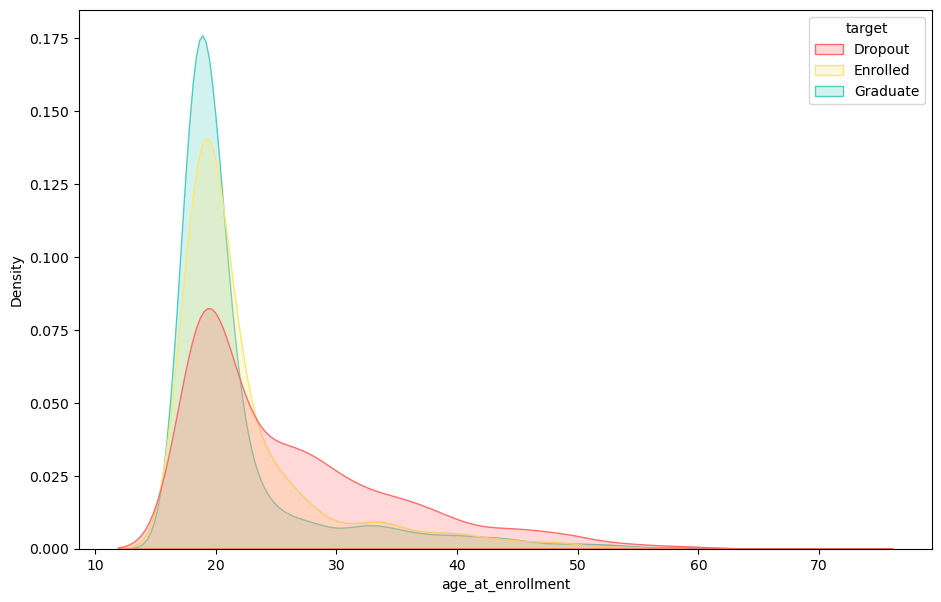

In [26]:
sns.kdeplot(students, x = "age_at_enrollment", hue = "target", fill = True, common_norm=False, palette=target_palette)

<AxesSubplot: xlabel='unemployment_rate', ylabel='Count'>

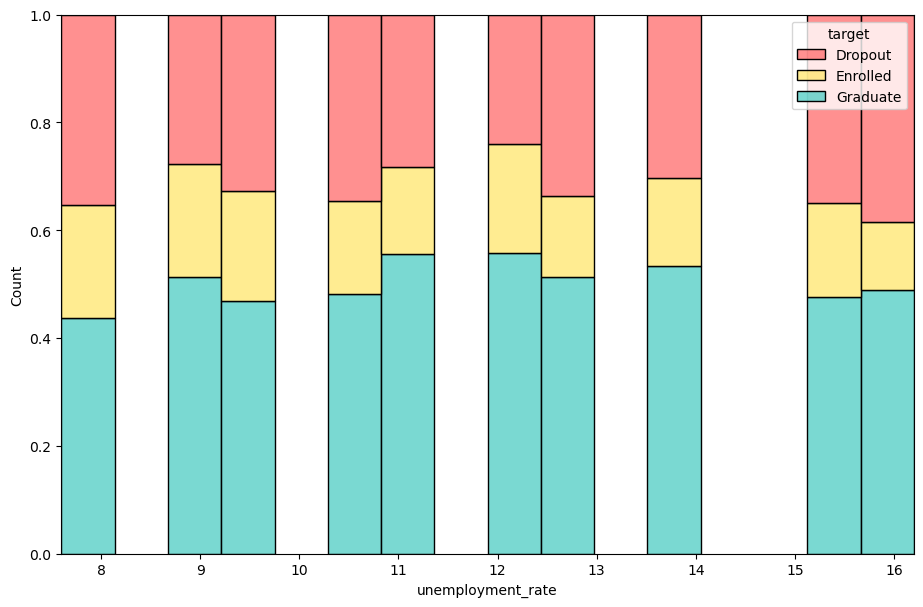

In [27]:
sns.histplot(students, x = "unemployment_rate", hue = "target", stat= "count", multiple="fill", palette=target_palette)

<AxesSubplot: xlabel='gdp', ylabel='Count'>

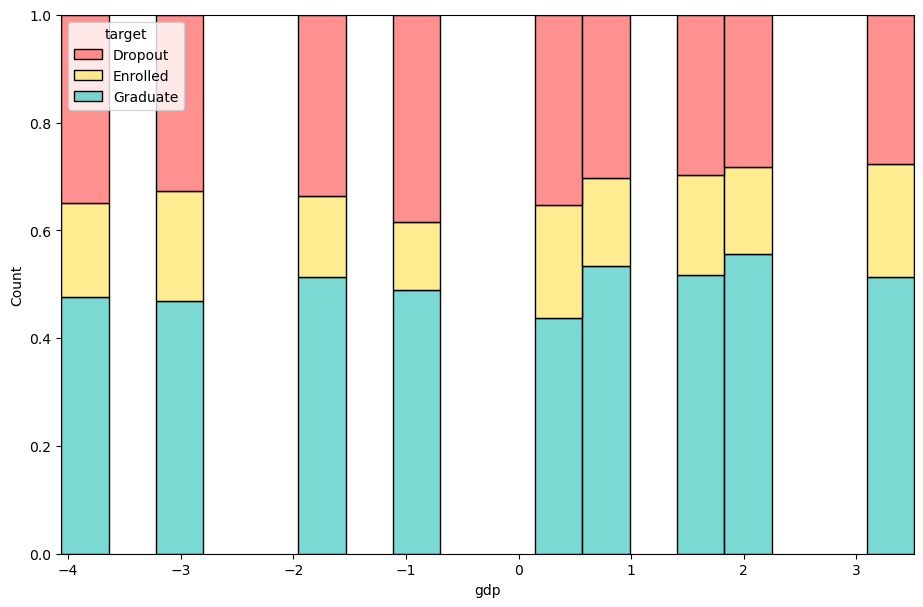

In [28]:
sns.histplot(students, x = "gdp", hue = "target", stat= "count", multiple="fill", palette=target_palette)

<AxesSubplot: xlabel='inflation_rate', ylabel='Count'>

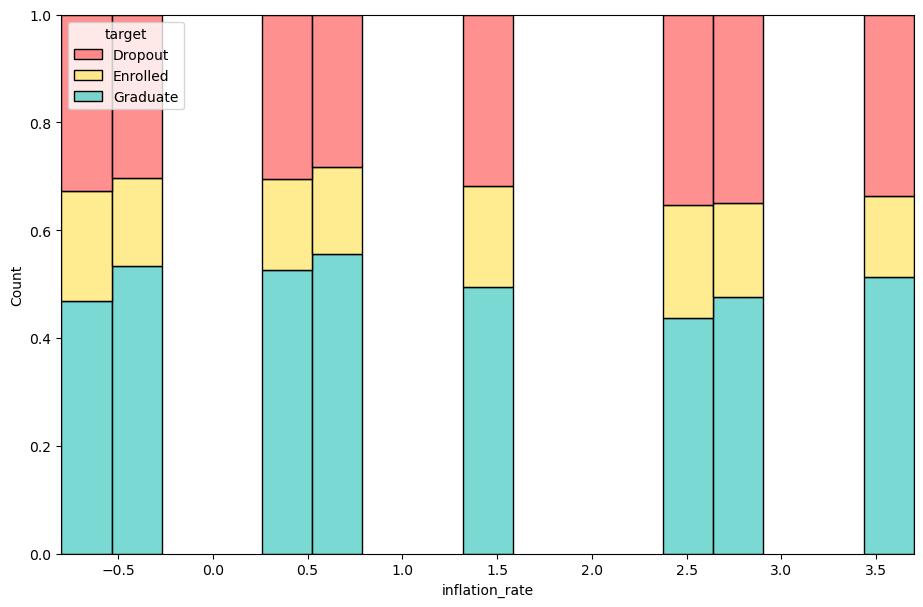

In [29]:
sns.histplot(students, x = "inflation_rate", hue = "target", stat= "count", multiple="fill", palette=target_palette)

# Bivariate analysis

In [8]:
academic_columns = students.columns[students.columns.str.contains("curricular")]
students[academic_columns].describe().T

count       mean       std  \
curricular_units_1st_sem_(credited)             4424.0   0.709991  2.360507   
curricular_units_1st_sem_(enrolled)             4424.0   6.270570  2.480178   
curricular_units_1st_sem_(evaluations)          4424.0   8.299051  4.179106   
curricular_units_1st_sem_(approved)             4424.0   4.706600  3.094238   
curricular_units_1st_sem_(grade)                4424.0  10.640822  4.843663   
curricular_units_1st_sem_(without_evaluations)  4424.0   0.137658  0.690880   
curricular_units_2nd_sem_(credited)             4424.0   0.541817  1.918546   
curricular_units_2nd_sem_(enrolled)             4424.0   6.232143  2.195951   
curricular_units_2nd_sem_(evaluations)          4424.0   8.063291  3.947951   
curricular_units_2nd_sem_(approved)             4424.0   4.435805  3.014764   
curricular_units_2nd_sem_(grade)                4424.0  10.230206  5.210808   
curricular_units_2nd_sem_(without_evaluations)  4424.0   0.150316  0.753774   

                                                min    25%        50%  \
curricular_units_1st_sem_(credited)             0.0   0.00   0.000000   
curricular_units_1st_sem_(enrolled)             0.0   5.00   6.000000   
curricular_units_1st_sem_(evaluations)          0.0   6.00   8.000000   
curricular_units_1st_sem_(approved)             0.0   3.00   5.000000   
curricular_units_1st_sem_(grade)                0.0  11.00  12.285714   
curricular_units_1st_sem_(without_evaluations)  0.0   0.00   0.000000   
curricular_units_2nd_sem_(credited)             0.0   0.00   0.000000   
curricular_units_2nd_sem_(enrolled)             0.0   5.00   6.000000   
curricular_units_2nd_sem_(evaluations)          0.0   6.00   8.000000   
curricular_units_2nd_sem_(approved)             0.0   2.00   5.000000   
curricular_units_2nd_sem_(grade)                0.0  10.75  12.200000   
curricular_units_2nd_sem_(without_evaluations)  0.0   0.00   0.000000   

                                                      75%        max  
curricular_units_1st_sem_(credited)              0.000000  20.000000  
curricular_units_1st_sem_(enrolled)              7.000000  26.000000  
curricular_units_1st_sem_(evaluations)          10.000000  45.000000  
curricular_units_1st_sem_(approved)              6.000000  26.000000  
curricular_units_1st_sem_(grade)                13.400000  18.875000  
curricular_units_1st_sem_(without_evaluations)   0.000000  12.000000  
curricular_units_2nd_sem_(credited)              0.000000  19.000000  
curricular_units_2nd_sem_(enrolled)              7.000000  23.000000  
curricular_units_2nd_sem_(evaluations)          10.000000  33.000000  
curricular_units_2nd_sem_(approved)              6.000000  20.000000  
curricular_units_2nd_sem_(grade)                13.333333  18.571429  
curricular_units_2nd_sem_(without_evaluations)   0.000000  12.000000

In [9]:
first_semester_evals = students[["curricular_units_1st_sem_(evaluations)", "curricular_units_1st_sem_(approved)", "target"]]
first_semester_evals.columns = ["evaluations", "approved", "target"]

In [32]:
all(first_semester_evals.assign(correct = lambda x: x.evaluations >= x.approved)["correct"])
# Checking if the number of evaluations is always greater or equal to the number of approved evaluations, it checks

True

<AxesSubplot: xlabel='evaluations', ylabel='pct_approved'>

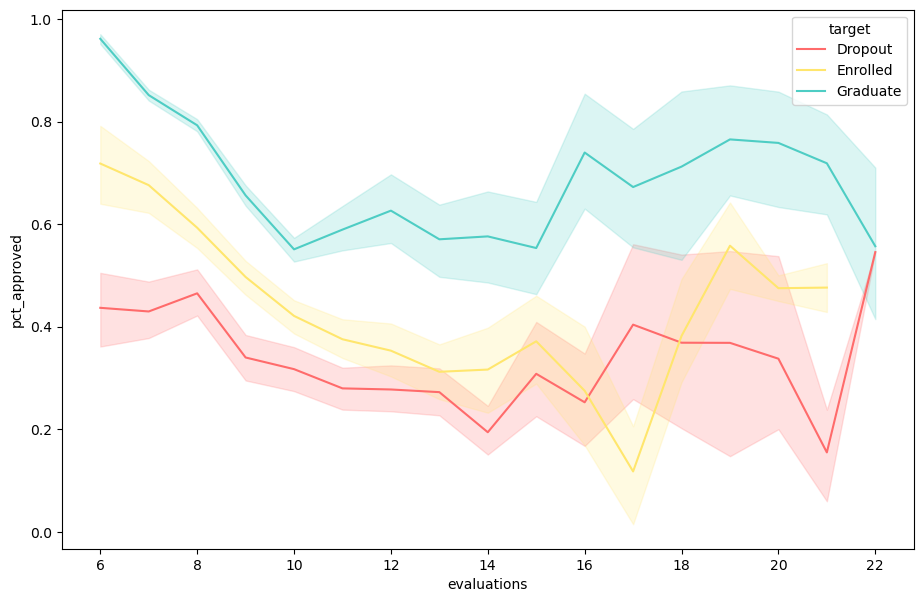

In [33]:
first_semester_evals = first_semester_evals.assign(pct_approved = lambda x: x.approved / x.evaluations).query("evaluations > 5")
sns.lineplot(first_semester_evals.query("evaluations <= 22"), x = "evaluations", y = "pct_approved", hue = "target", palette=target_palette)

This one looks like a really good predictor, there is a clear difference between students who graduate on time and the others, and this is just information from the first semester of the course! Lets check the second semester

<AxesSubplot: xlabel='evaluations', ylabel='pct_approved'>

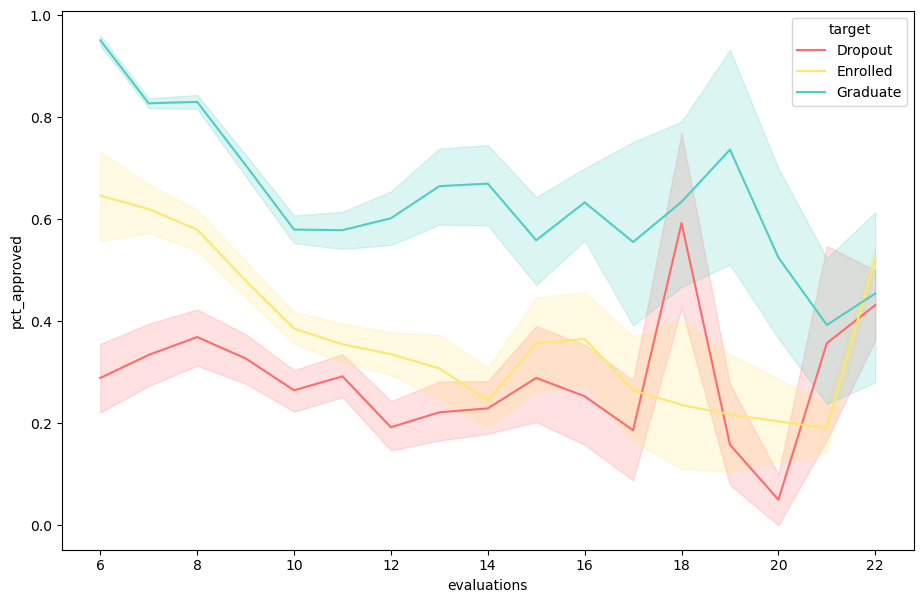

In [34]:
second_semester_evals = students[["curricular_units_2nd_sem_(evaluations)", "curricular_units_2nd_sem_(approved)", "target"]]
second_semester_evals.columns = ["evaluations", "approved", "target"]
second_semester_evals = second_semester_evals.assign(pct_approved = lambda x: x.approved / x.evaluations)\
    .query("evaluations > 5")
sns.lineplot(second_semester_evals.query("evaluations <= 22"), x = "evaluations", y = "pct_approved", hue = "target", palette = target_palette)

Again this is a good predictor. Probably I should do some dimensionality reductions or clustering with these academic data variables, because they seem to be very correlated with the output

## Correlation analysis

In [10]:
students_nums = pd.read_csv("../data/students_processed.csv")
le = LabelEncoder()
students_nums["target"] = le.fit_transform(students_nums["target"])

In [36]:
le.classes_

array(['Dropout', 'Enrolled', 'Graduate'], dtype=object)

<AxesSubplot: >

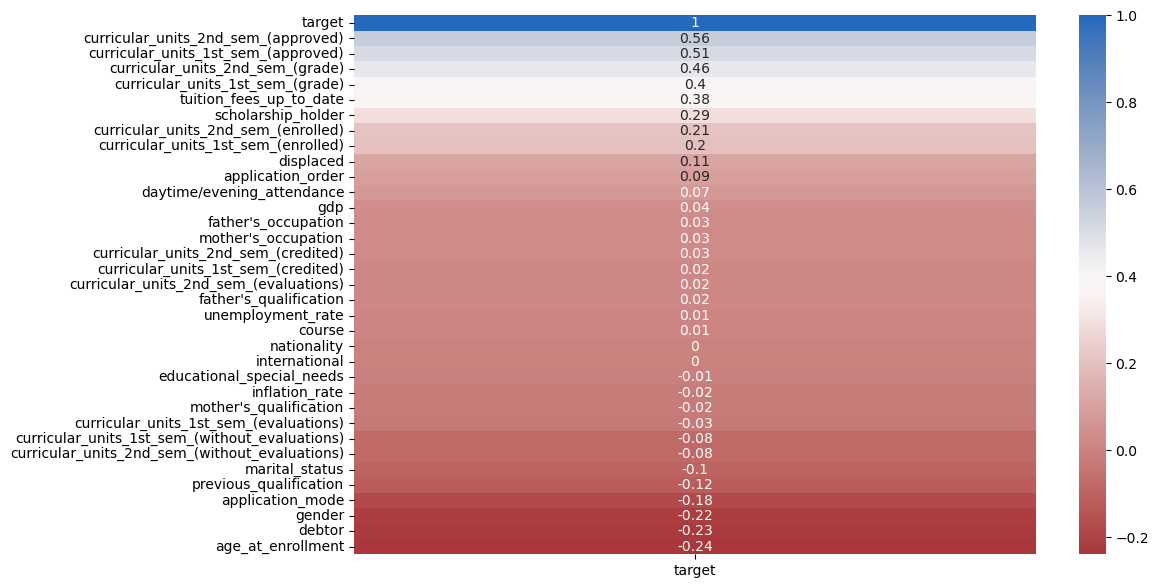

In [37]:
corr_mat = students_nums.corr(method = "kendall").round(2)
sns.heatmap(corr_mat[["target"]].sort_values("target", ascending = False), cmap = "vlag_r", annot = True)

<AxesSubplot: >

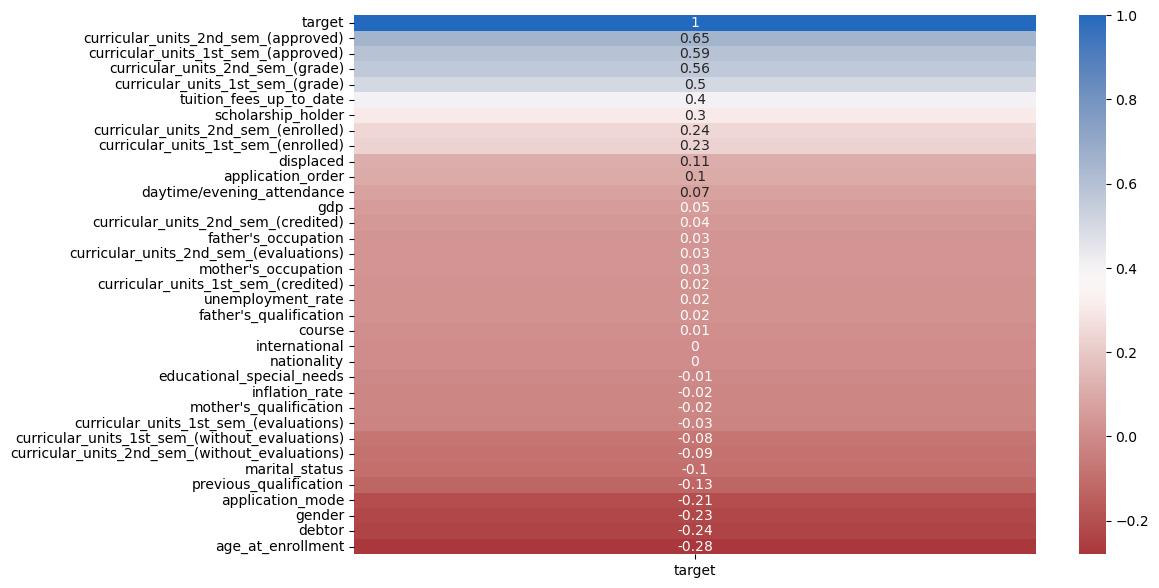

In [38]:
corr_mat = students_nums.corr(method = "spearman").round(2)
sns.heatmap(corr_mat[["target"]].sort_values("target", ascending = False), cmap = "vlag_r", annot = True)

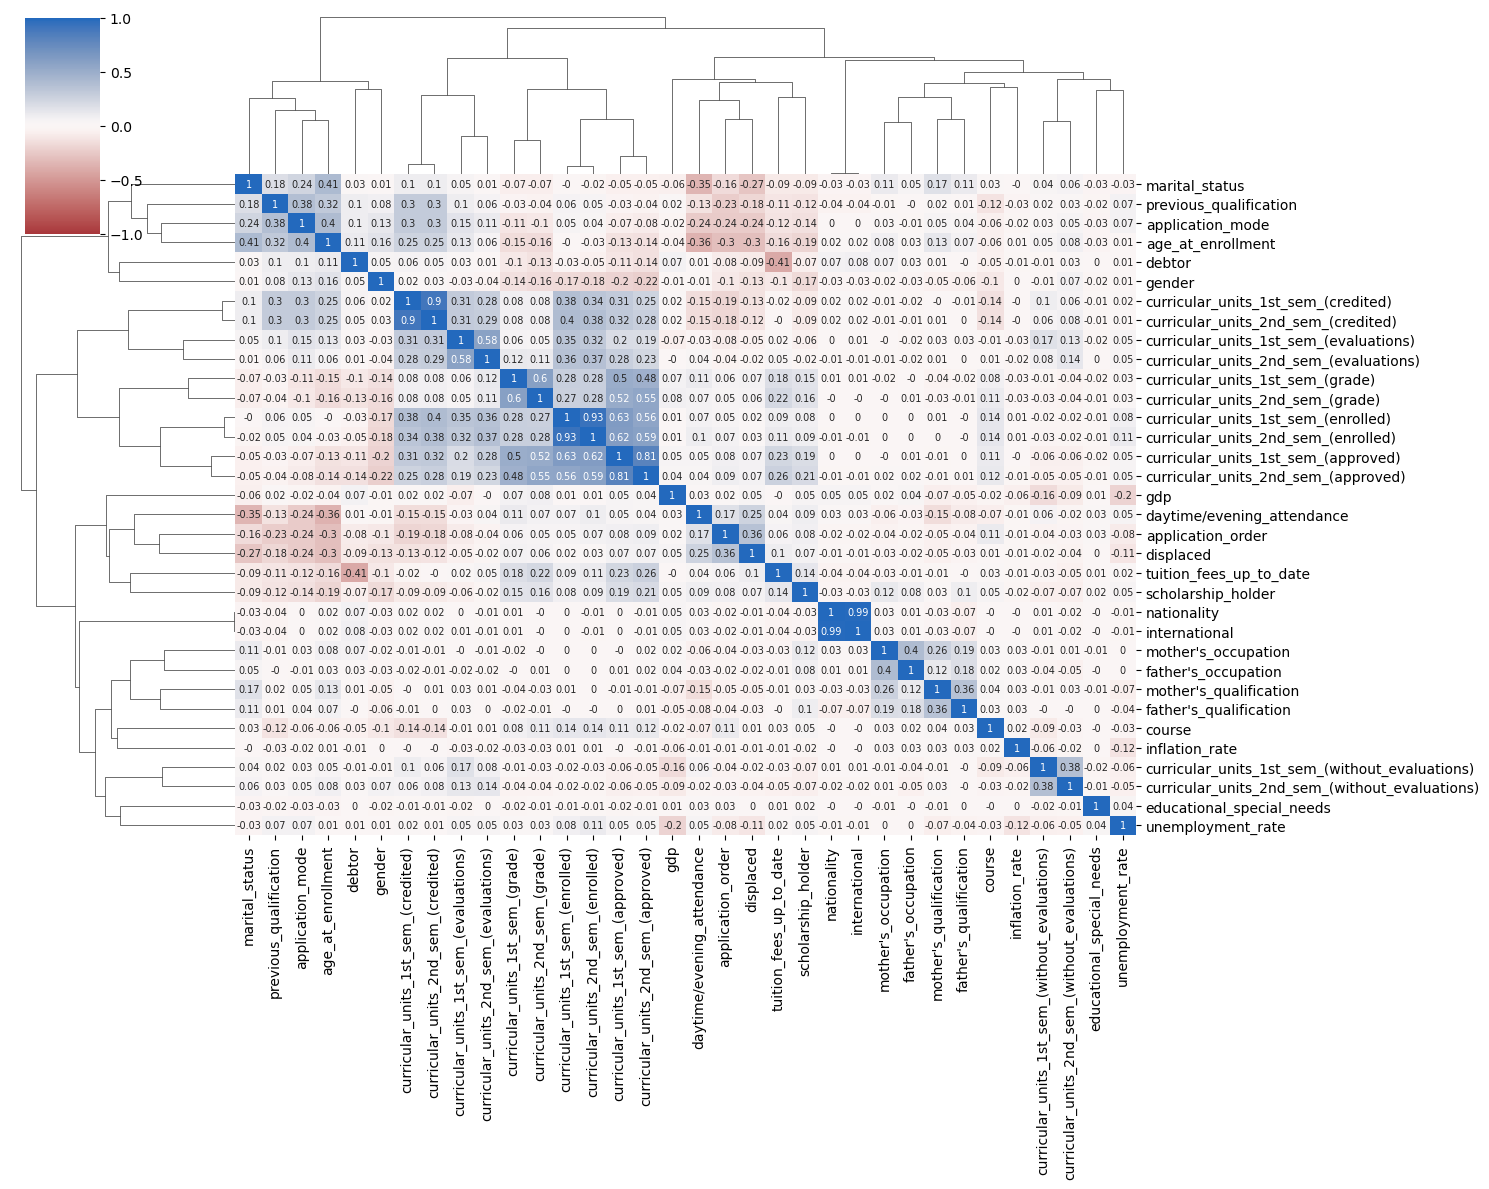

In [39]:
g = sns.clustermap(students_nums.drop(columns = "target").corr(method = "kendall").round(2), method="complete", cmap='vlag_r', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

Looks like there are some clusters in our data, the biggest one being the academic data variables. I will try to make a umap transformation on these variables and see how do they relate to the target

## UMAP on academic data

As seen above, the academic variables are highly skewed and with a lot of zeroes and outliers, that's why I will use the robust scaler before performing the dimensionality reduction.

This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

Standardization of a dataset is a common requirement for many machine learning estimators. Typically this is done by removing the mean and scaling to unit variance. However, outliers can often influence the sample mean / variance in a negative way. In such cases, the median and the interquartile range often give better results.

In [11]:
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from umap import UMAP

In [76]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

students_academic = students[academic_columns].copy()

students_academic_robust_sc = robust_scaler.fit_transform(students_academic)
students_academic_standard_sc = standard_scaler.fit_transform(students_academic)

target_encoder = LabelEncoder()
target_enc = target_encoder.fit_transform(students["target"])

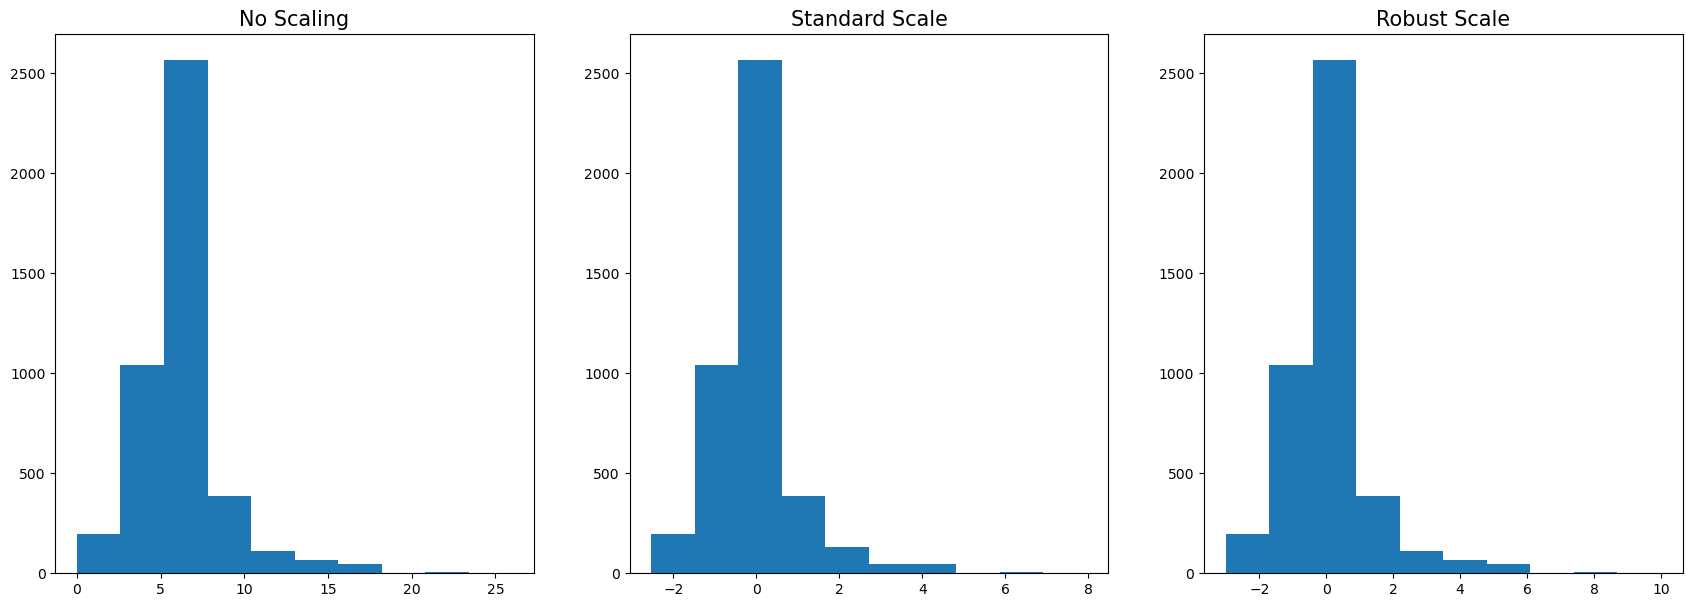

In [82]:
column_number = 1

fig, ax = plt.subplots(1, 3, figsize = (21, 7))
ax[0].hist(students_academic.iloc[:,column_number])
ax[0].set_title("No Scaling", fontsize = 15)
ax[1].hist(students_academic_standard_sc[:,column_number])
ax[1].set_title("Standard Scale", fontsize = 15)
ax[2].hist(students_academic_robust_sc[:,column_number])
ax[2].set_title("Robust Scale", fontsize = 15)
plt.show()

In [85]:
for col in range(students_academic_robust_sc.shape[1]):
    print(f"The mean of the {students_academic.columns[col]} column is {students_academic_robust_sc[:,col].mean()}; sd = {students_academic_robust_sc[:,col].std()} ")

The mean of the curricular_units_1st_sem_(credited) column is 0.7099909584086799; sd = 2.3602398198385526 
The mean of the curricular_units_1st_sem_(enrolled) column is 0.13528481012658228; sd = 1.2399489249984093 
The mean of the curricular_units_1st_sem_(evaluations) column is 0.0747626582278481; sd = 1.0446583050980325 
The mean of the curricular_units_1st_sem_(approved) column is -0.09779987944544909; sd = 1.0312960831629603 
The mean of the curricular_units_1st_sem_(grade) column is -0.6853719627333752; sd = 2.0179649664230452 
The mean of the curricular_units_1st_sem_(without_evaluations) column is 0.13765822784810128; sd = 0.6908020961134163 
The mean of the curricular_units_2nd_sem_(credited) column is 0.5418173598553345; sd = 1.9183292975785422 
The mean of the curricular_units_2nd_sem_(enrolled) column is 0.11607142857142858; sd = 1.0978512756605001 
The mean of the curricular_units_2nd_sem_(evaluations) column is 0.015822784810126583; sd = 0.986876179808235 
The mean of the 

In [87]:
for col in range(students_academic.shape[1]):
    print(f"The mean of the {students_academic.columns[col]} column is {students_academic.iloc[:,col].mean()}; sd = {students_academic.iloc[:,col].std()} ")

The mean of the curricular_units_1st_sem_(credited) column is 0.7099909584086799; sd = 2.3605066191181976 
The mean of the curricular_units_1st_sem_(enrolled) column is 6.2705696202531644; sd = 2.480178175307158 
The mean of the curricular_units_1st_sem_(evaluations) column is 8.299050632911392; sd = 4.179105569144036 
The mean of the curricular_units_1st_sem_(approved) column is 4.706600361663653; sd = 3.094237979693975 
The mean of the curricular_units_1st_sem_(grade) column is 10.640821575154185; sd = 4.843663380663813 
The mean of the curricular_units_1st_sem_(without_evaluations) column is 0.13765822784810128; sd = 0.6908801837297979 
The mean of the curricular_units_2nd_sem_(credited) column is 0.5418173598553345; sd = 1.9185461437101994 
The mean of the curricular_units_2nd_sem_(enrolled) column is 6.232142857142857; sd = 2.1959507514632417 
The mean of the curricular_units_2nd_sem_(evaluations) column is 8.063291139240507; sd = 3.94795094143741 
The mean of the curricular_units

In [89]:
embedding = UMAP().fit_transform(students_academic_robust_sc, target_enc)

<AxesSubplot: >

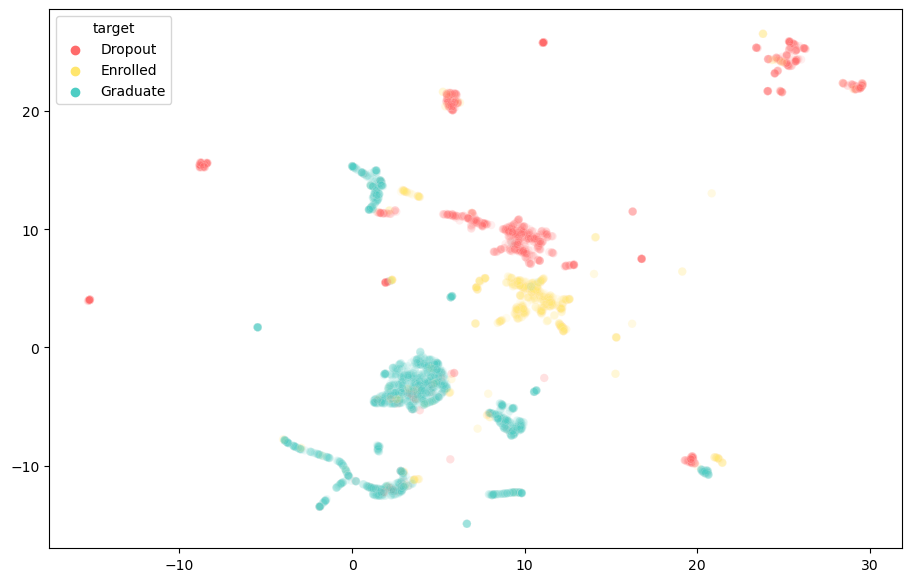

In [93]:
sns.scatterplot(x = embedding[:,0], y = embedding[:,1], hue = students["target"], palette = target_palette, alpha = 0.1)

## PCA on academic data

In [94]:
# PCA Analysis

from sklearn.decomposition import PCA

pca = PCA()
pca_rs = pca.fit_transform(students_academic_robust_sc)
pca_df = pd.DataFrame(pca_rs, columns = [f"PC{i + 1}" for i in range(pca_rs.shape[1])])

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

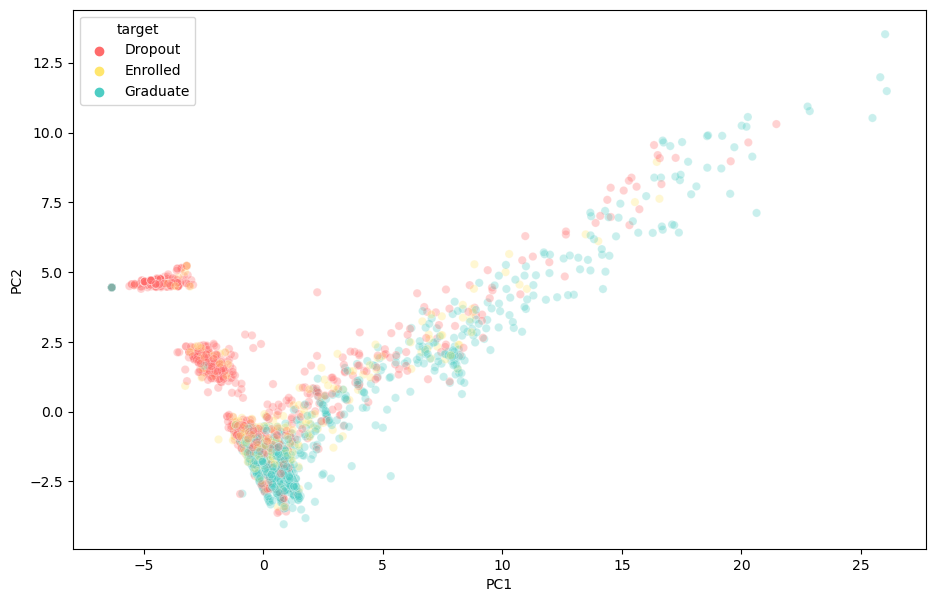

In [95]:
sns.scatterplot(x = pca_df["PC1"], y = pca_df["PC2"], hue = students["target"], palette = target_palette, alpha = 0.3)

We can see a that PCA does a worst job at dividing the categories than UMAP. UMAP has the advantage of using the target to do supervised dimensionality reduction.

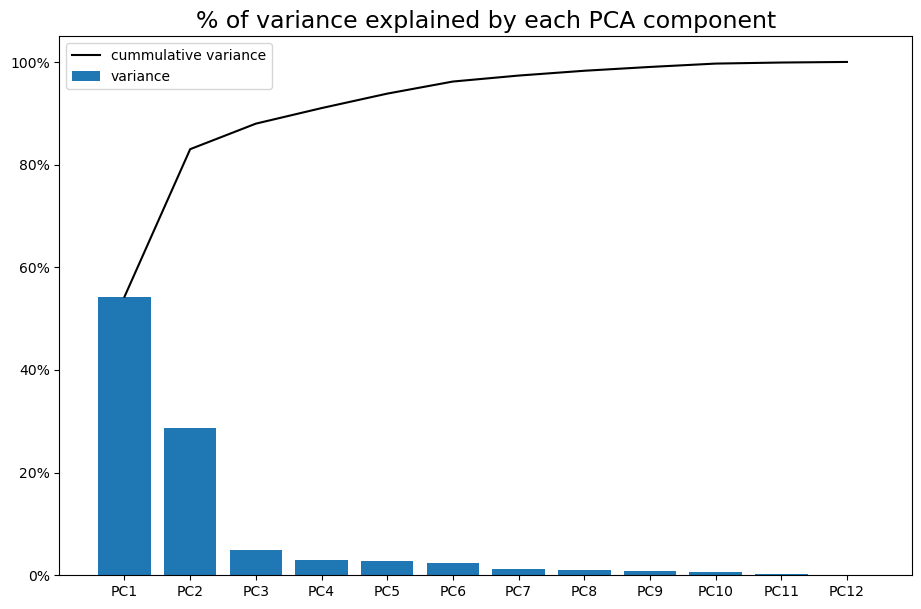

In [96]:
plt.bar(x = range(pca_rs.shape[1]), height= pca.explained_variance_ratio_)
plt.plot(range(pca_rs.shape[1]), pca.explained_variance_ratio_.cumsum(), c = "black")
plt.legend(["cummulative variance", "variance"])
plt.xticks(ticks = range(pca_rs.shape[1]), labels = [f"PC{i + 1}" for i in range(pca_rs.shape[1])])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("% of variance explained by each PCA component", fontsize = 17)
plt.show()

In [97]:
pca_comps = pd.DataFrame(pca.components_, index = pca_df.columns, columns = academic_columns).reset_index(names = "component")

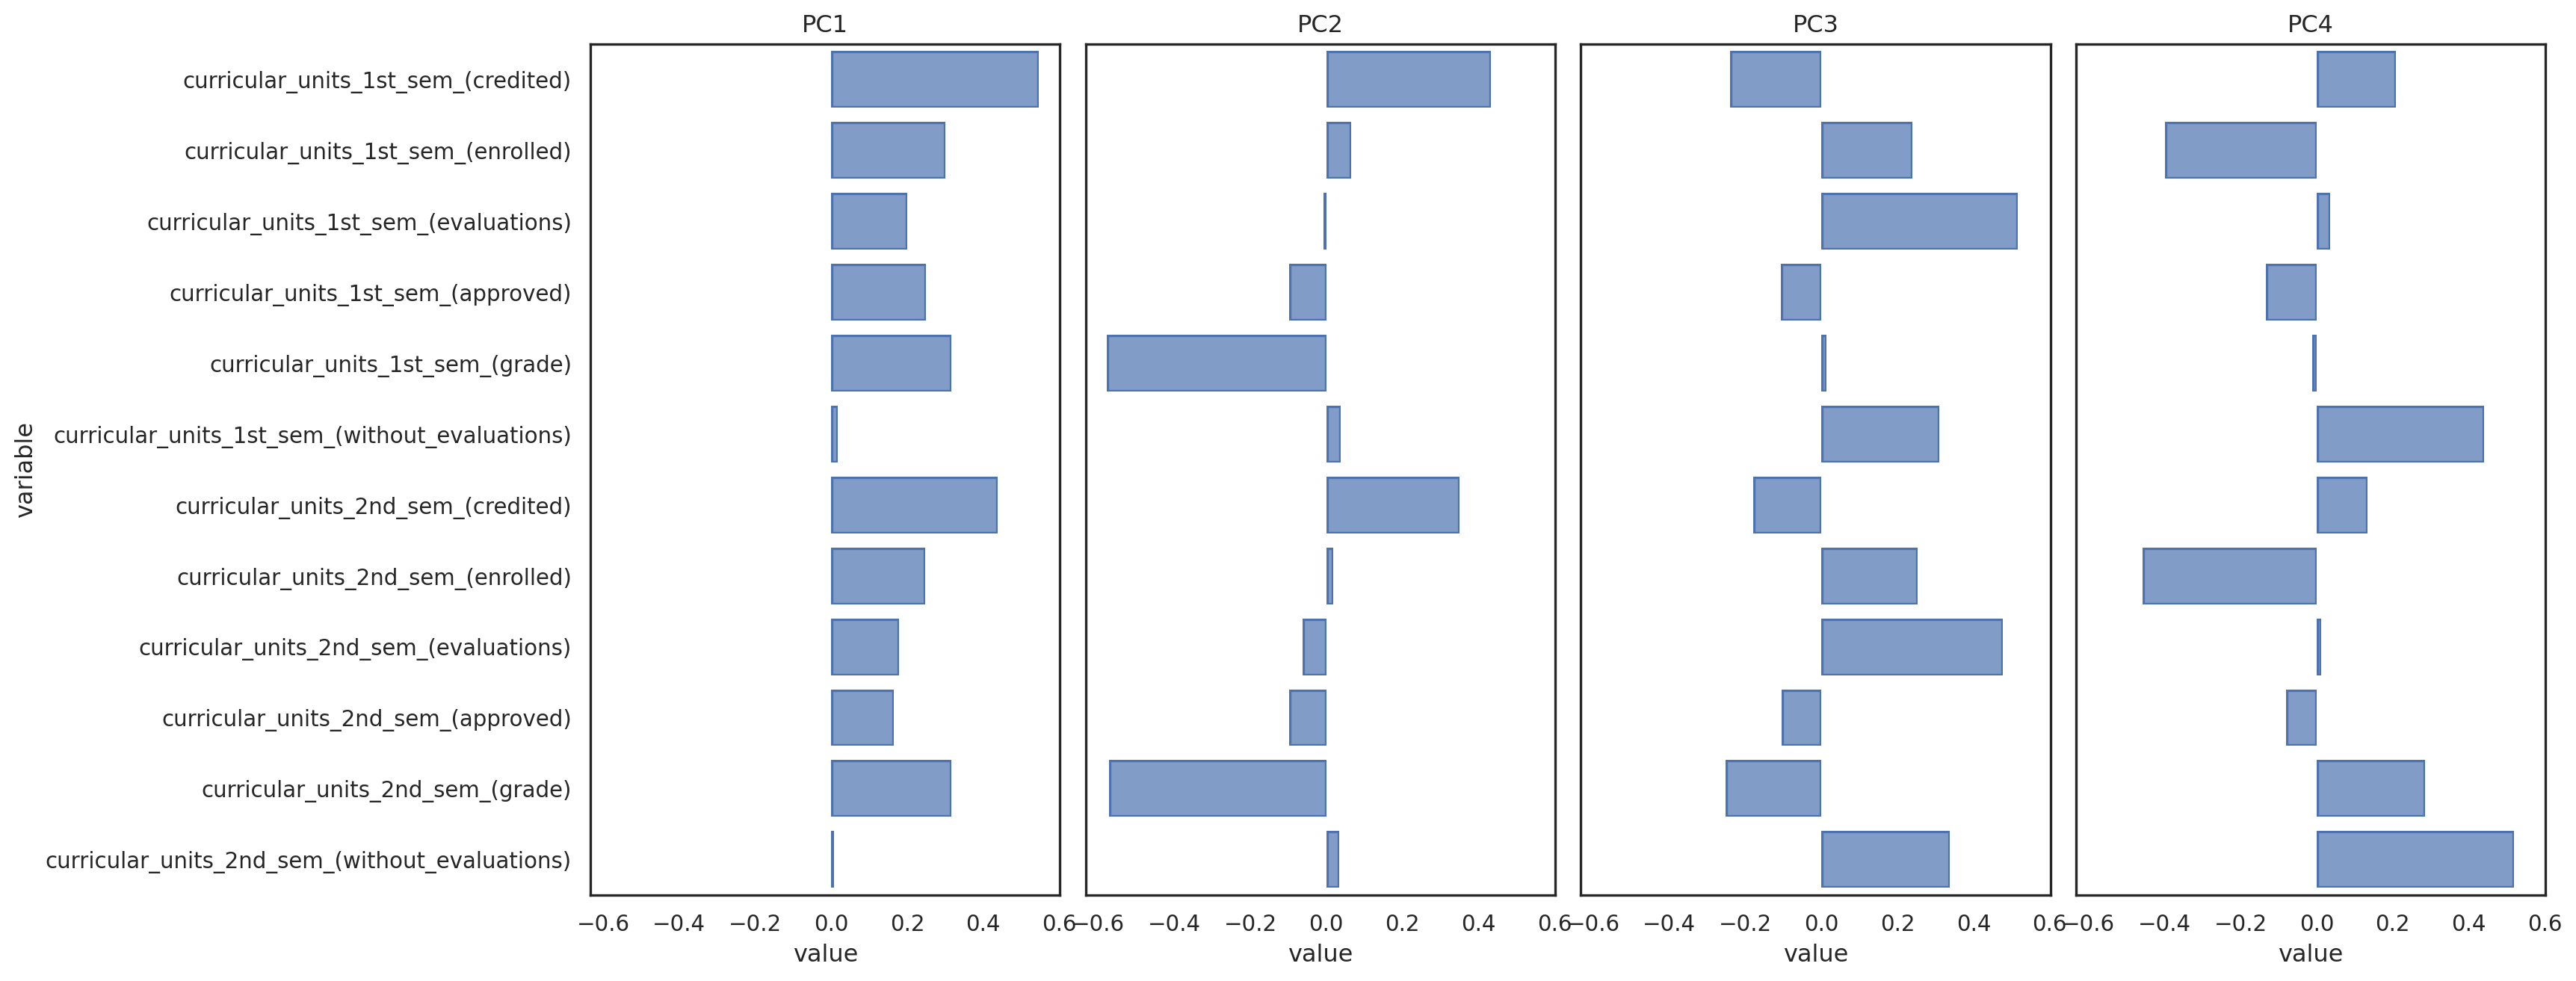

In [98]:
pca_comps_long = pca_comps.melt(id_vars = "component").query("component.isin(['PC1','PC2','PC3','PC4'])")

(
    so.Plot(pca_comps_long, "value", "variable")
    .add(so.Bar())
    .facet("component", wrap = 4)
    .layout(size = (18,7))
    .theme({**axes_style("white")})
)

Higher credited and lower grade means dropout?? CHECK

Most of the variance in the PCA analysis is explained by the first 3 components. I will try to extend the UMAP analysis to 3 components also to see if there is and improvement on the division of the categories

<AxesSubplot: xlabel='curricular_units_1st_sem_(credited)', ylabel='curricular_units_2nd_sem_(credited)'>

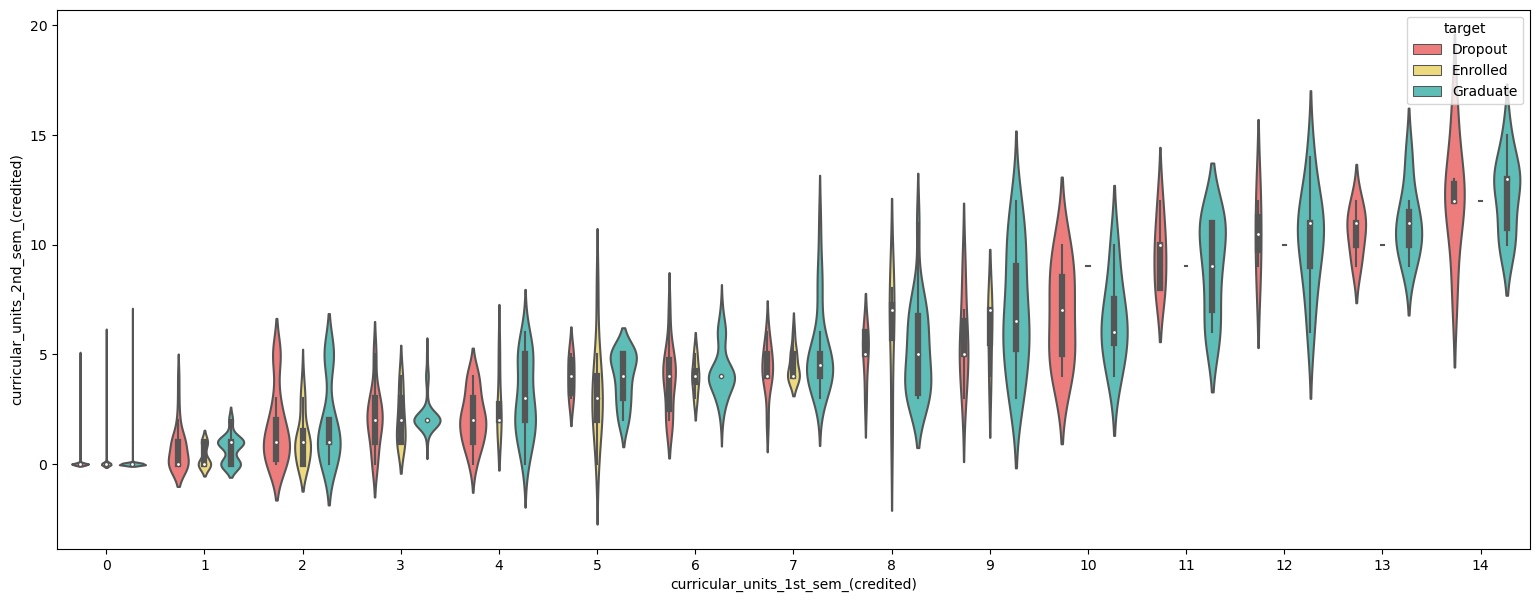

In [24]:
plt.figure(figsize = (19,7))
sns.violinplot(students[students["curricular_units_1st_sem_(credited)"] < 15], x = "curricular_units_1st_sem_(credited)", y = "curricular_units_2nd_sem_(credited)", hue = "target",
            palette=target_palette, scale = "count")

In [100]:
embedding_3d = UMAP(n_components=3, n_neighbors=10).fit_transform(students_academic_robust_sc, target_enc)
embedding_3d_df = pd.DataFrame(embedding_3d, columns = [f"UMAP{i}" for i in range(1,4)])

In [103]:
fig = px.scatter_3d(embedding_3d_df, x='UMAP1', y='UMAP2', z='UMAP3',color=students["target"],
                    title="Students academic variables - UMAP", height = 800, width = 1100,
                    color_discrete_map=target_palette,
                    opacity = 0.2)
fig.show()

From the visual analysis, the 3 components UMAP is doing better than the 2 components UMAP to discriminate the different categories. If I will use this as a preprocessing step in the classification model, I will have to tune this hyperparameter

# Questions

### 1.  Why is there a difference between men and women in dropouts? Is it related with the chosen course?

I will compare the dropouts vs non-dropouts

In [86]:
import statsmodels.formula.api as smf
students_dropout = students.copy()
students_dropout["target"] = np.where(students["target"] == "Dropout", 1, 0)

In [87]:
students_dropout.target.value_counts()

0    3003
1    1421
Name: target, dtype: int64

This first model will only include gender as a predictor, to use as a base model for comparison

In [96]:
model = smf.logit("target ~ gender", students_dropout).fit()
result = pd.concat([model.params, model.conf_int()], axis = 1)
result.columns = ['odds ratio', '5%', '95%']
result = np.exp(result)
p = model.pvalues.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
result["p values"] = model.pvalues.round(3).astype(str) + p
result

Optimization terminated successfully.
         Current function value: 0.607362
         Iterations 5


odds ratio        5%       95% p values
Intercept         0.335196  0.308065  0.364715   0.0***
gender[T.male]    2.445984  2.146189  2.787658   0.0***

Only using gender as a predictor we can see there is a significative difference between men and women in terms of dropout. Men have 2.4 times the odds of women of dropping out their courses

Based on the data, we can expect an increase of 114% to 178% in the odds of dropout for men compared to women

What happens if we include the course in the analysis?

In [98]:
model = smf.logit("target ~ gender + course", students_dropout).fit()
result = pd.concat([model.params, model.conf_int()], axis = 1)
result.columns = ['odds ratio', '5%', '95%']
result = np.exp(result)
p = model.pvalues.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
result["p values"] = model.pvalues.round(3).astype(str) + p
result

Optimization terminated successfully.
         Current function value: 0.582247
         Iterations 6


odds ratio        5%  \
Intercept                                        0.384048  0.294626   
gender[T.male]                                   2.101506  1.813090   
course[T.Agronomy]                               1.052612  0.720703   
course[T.Animation and Multimedia Design]        1.053618  0.721913   
course[T.Basic Education]                        1.997623  1.354604   
course[T.Biofuel Production Technologies]        3.028462  0.874492   
course[T.Communication Design]                   0.533494  0.355701   
course[T.Equiniculture]                          2.345002  1.536485   
course[T.Informatics Engineering]                1.506317  1.008930   
course[T.Journalism and Communication]           0.863221  0.609461   
course[T.Management]                             1.013879  0.727296   
course[T.Management (evening attendance)]        1.842061  1.295321   
course[T.Nursing]                                0.397878  0.287825   
course[T.Oral Hygiene]                           1.364810  0.819897   
course[T.Social Service]                         0.519653  0.357349   
course[T.Social Service (evening attendance)]    1.096915  0.745717   
course[T.Tourism]                                1.176291  0.818519   
course[T.Veterinary Nursing]                     0.817027  0.573082   

                                                     95%  p values  
Intercept                                       0.500609    0.0***  
gender[T.male]                                  2.435803    0.0***  
course[T.Agronomy]                              1.537379     0.791  
course[T.Animation and Multimedia Design]       1.537735     0.787  
course[T.Basic Education]                       2.945878    0.0***  
course[T.Biofuel Production Technologies]      10.487891      0.08  
course[T.Communication Design]                  0.800155   0.002**  
course[T.Equiniculture]                         3.578969    0.0***  
course[T.Informatics Engineering]               2.248907    0.045*  
course[T.Journalism and Communication]          1.222639     0.408  
course[T.Management]                            1.413386     0.935  
course[T.Management (evening attendance)]       2.619573  0.001***  
course[T.Nursing]                               0.550011    0.0***  
course[T.Oral Hygiene]                          2.271877     0.232  
course[T.Social Service]                        0.755674  0.001***  
course[T.Social Service (evening attendance)]   1.613512     0.639  
course[T.Tourism]                               1.690445      0.38  
course[T.Veterinary Nursing]                    1.164812     0.264

When we include the course in the predictors, the odds drop a bit, but there is still a significant difference between the dropouts of men compared to women. What does a data visualization says?

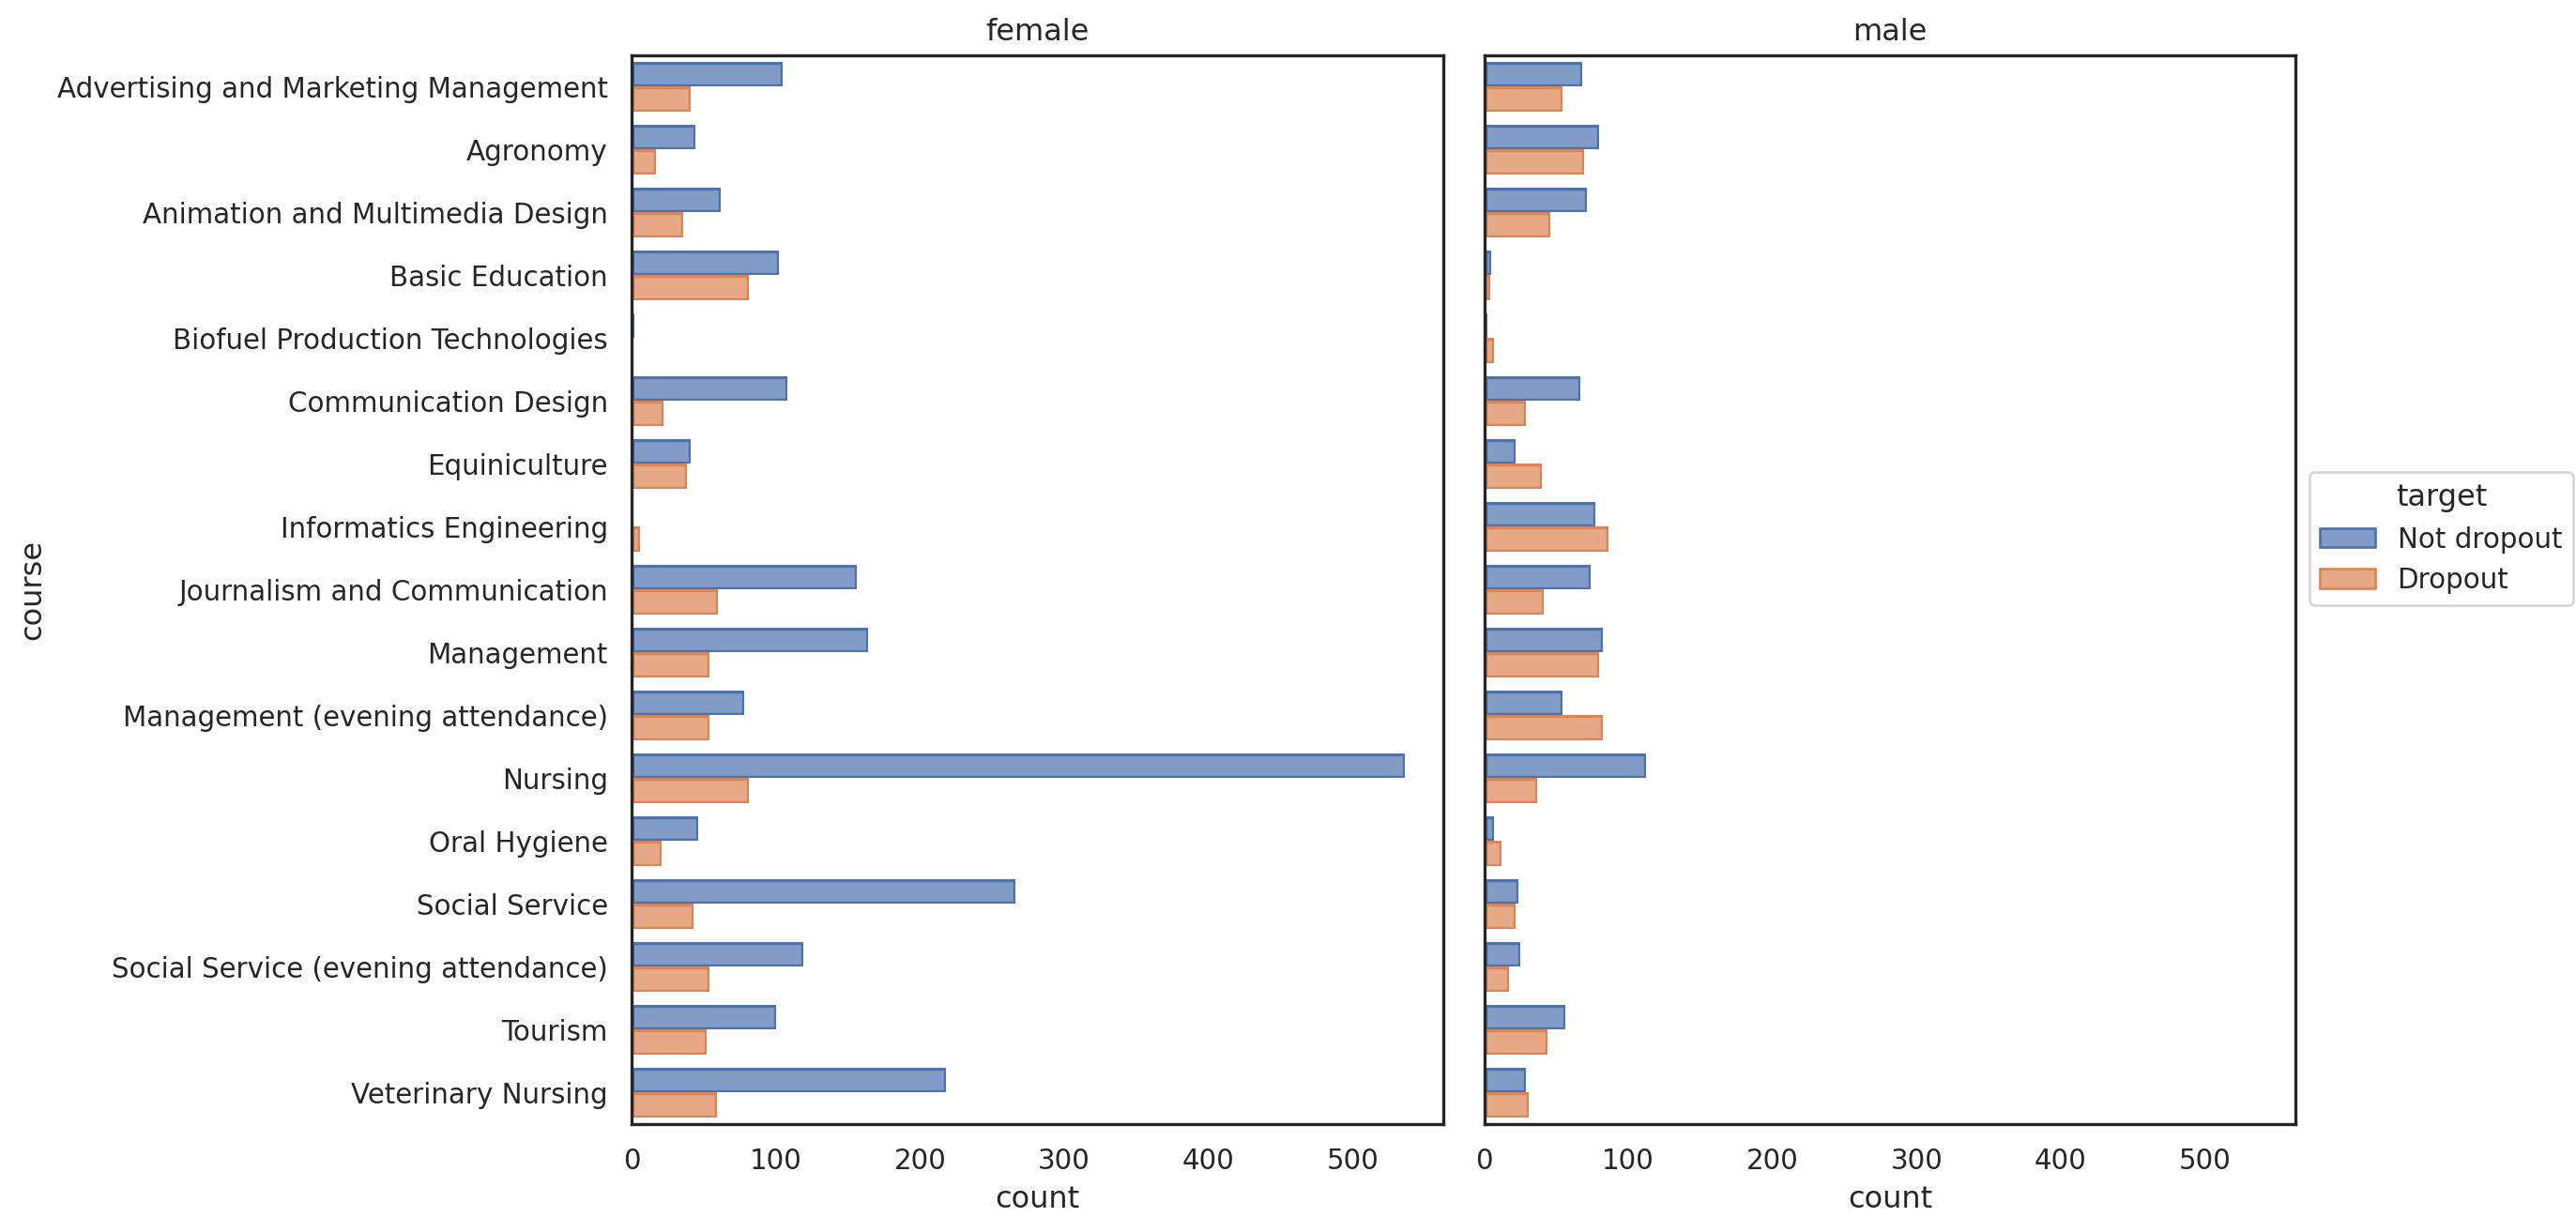

In [138]:
data_filter = (
    students_dropout.groupby(["gender", "course"], as_index=False)["target"]
    .value_counts()
    .assign(target=lambda x: x.target.map({0: "Not dropout", 1: "Dropout"}))
)
(
    so.Plot(data_filter, y="course", x="count", color="target")
    .facet("gender")
    .layout(size=(13, 7), engine="tight")
    .add(so.Bar(), so.Dodge())
    .theme({**axes_style("white")})
)

The visualization confirms what the model say, in almost all the courses women are more likely to not dropout than men

In [113]:
model = smf.logit("target ~ gender + course + age_at_enrollment + scholarship_holder + marital_status", students_dropout).fit()
result = pd.concat([model.params, model.conf_int()], axis = 1)
result.columns = ['odds ratio', '5%', '95%']
result = np.exp(result)
p = model.pvalues.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
result["p values"] = model.pvalues.round(3).astype(str) + p
result

Optimization terminated successfully.
         Current function value: 0.542588
         Iterations 6


odds ratio        5%  \
Intercept                                        0.089920  0.044689   
gender[T.male]                                   1.720988  1.474046   
course[T.Agronomy]                               0.639225  0.428459   
course[T.Animation and Multimedia Design]        1.183705  0.800995   
course[T.Basic Education]                        1.822882  1.215581   
course[T.Biofuel Production Technologies]        1.476228  0.419589   
course[T.Communication Design]                   0.560962  0.368333   
course[T.Equiniculture]                          1.929916  1.245576   
course[T.Informatics Engineering]                1.359723  0.897018   
course[T.Journalism and Communication]           0.954439  0.663274   
course[T.Management]                             0.876616  0.619390   
course[T.Management (evening attendance)]        0.840771  0.573403   
course[T.Nursing]                                0.408003  0.291571   
course[T.Oral Hygiene]                           1.131555  0.657287   
course[T.Social Service]                         0.535607  0.362593   
course[T.Social Service (evening attendance)]    0.436241  0.282962   
course[T.Tourism]                                1.157681  0.791418   
course[T.Veterinary Nursing]                     0.695617  0.481854   
scholarship_holder[T.yes]                        0.304395  0.248294   
marital_status[T.Facto union]                    1.194696  0.448757   
marital_status[T.Legally separated]              3.623231  0.524023   
marital_status[T.Married]                        0.811864  0.489523   
marital_status[T.Single]                         1.252070  0.758795   
marital_status[T.Widower]                        0.347742  0.025957   
age_at_enrollment                                1.075404  1.061398   

                                                     95% p values  
Intercept                                       0.180932   0.0***  
gender[T.male]                                  2.009300   0.0***  
course[T.Agronomy]                              0.953671   0.028*  
course[T.Animation and Multimedia Design]       1.749269    0.397  
course[T.Basic Education]                       2.733587  0.004**  
course[T.Biofuel Production Technologies]       5.193773    0.544  
course[T.Communication Design]                  0.854330  0.007**  
course[T.Equiniculture]                         2.990243  0.003**  
course[T.Informatics Engineering]               2.061104    0.148  
course[T.Journalism and Communication]          1.373419    0.802  
course[T.Management]                            1.240664    0.457  
course[T.Management (evening attendance)]       1.232807    0.374  
course[T.Nursing]                               0.570931   0.0***  
course[T.Oral Hygiene]                          1.948035    0.656  
course[T.Social Service]                        0.791177  0.002**  
course[T.Social Service (evening attendance)]   0.672551   0.0***  
course[T.Tourism]                               1.693448    0.451  
course[T.Veterinary Nursing]                    1.004211    0.053  
scholarship_holder[T.yes]                       0.373172   0.0***  
marital_status[T.Facto union]                   3.180559    0.722  
marital_status[T.Legally separated]            25.051960    0.192  
marital_status[T.Married]                       1.346461    0.419  
marital_status[T.Single]                        2.066011    0.379  
marital_status[T.Widower]                       4.658585    0.425  
age_at_enrollment                               1.089594   0.0***

Considering age of enrollment, course, scholarship holder and marital status predictors, the gender of the student is still a determining factor to predict whether he/she will dropout in the future. The odds of dropout are 1.72 times higher form men than for women. There is another variable that would be interesting to consider. Another interesting point to note is that those who are scholarship holders are less likely to dropout, which supports what we have seen in the univariate analysis. Finally, age of enrollment have statistical significance in this model, implying that older people are a little more likely to dropout.

How does this simple model perform?

Optimization terminated successfully.
         Current function value: 0.542222
         Iterations 6


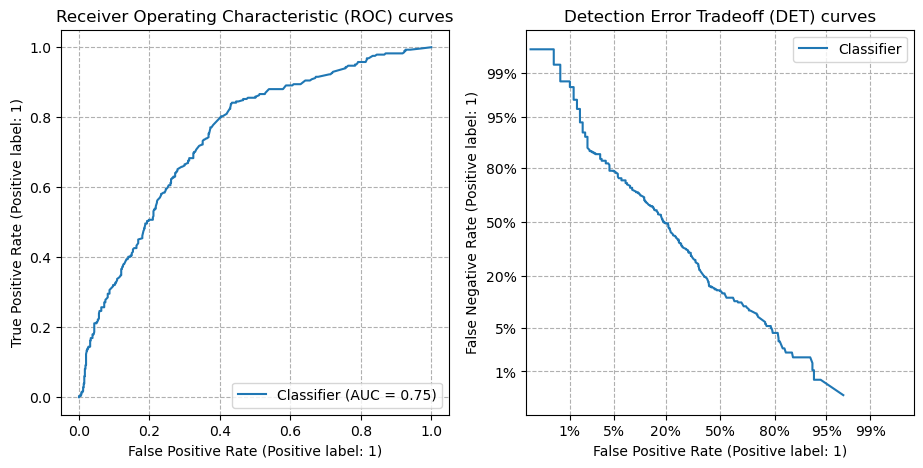

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

train, test = train_test_split(students_dropout, test_size = 0.20, stratify=students_dropout["target"])

model = smf.logit("target ~ gender + course + age_at_enrollment + scholarship_holder + marital_status", train).fit()

predictions = model.predict(test).values

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

RocCurveDisplay.from_predictions(test["target"].values, predictions, ax=ax_roc)
DetCurveDisplay.from_predictions(test["target"].values, predictions , ax=ax_det)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

In [123]:
from sklearn.metrics import classification_report

print(classification_report(test["target"].values, predictions > 0.5))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       601
           1       0.59      0.33      0.43       284

    accuracy                           0.71       885
   macro avg       0.67      0.61      0.62       885
weighted avg       0.69      0.71      0.69       885



The estimator is better than random, which is not bad considering we are using only a subset of the data, and no feature engineering was applied on it. The dataset is imbalanced, and the recall metric for this estimator is really low, which means it's having trouble predicting the rarest category (dropout) correctly, only detecting 33% of the cases. When training estimators in the whole data I will have to be aware of this imbalance situation, and use an adequate metric to measure the performance of the classifier.